In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats as scipy_stats
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")

## 1. تحميل البيانات

In [2]:
df = pd.read_csv('../data/raw/train.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Ticker', 'Date'])

print(f"Number of Ticker: {df['Ticker'].nunique()}")
print(f"Number of records: {len(df)}")
print(f"Time range: from {df['Date'].min()} to {df['Date'].max()}")

Number of Ticker: 5000
Number of records: 21033522
Time range: from 1962-01-02 00:00:00 to 2024-09-23 00:00:00


## 2. نظرة عامة: المفاهيم الأساسية

### المصطلحات الأساسية:

**1. Trend (الاتجاه):**
- يمثل الحركة طويلة المدى للبيانات
- يجيب على السؤال: هل السعر يتجه للأعلى، للأسفل، أم مستقر على المدى الطويل؟
- يتم حسابه عادة باستخدام المتوسطات المتحركة (Moving Averages)

**2. Seasonality (الموسمية):**
- الأنماط المتكررة في فترات زمنية ثابتة (يومية، أسبوعية، شهرية، سنوية)
- مثال: ارتفاع المبيعات في مواسم معينة، أو تأثير بداية الشهر/السنة على الأسواق
- في أسعار الأسهم: قد نرى أنماط شهرية أو ربع سنوية مرتبطة بإعلانات الأرباح

**3. Residuals (البقايا/التقلبات العشوائية):**
- ما تبقى بعد إزالة الاتجاه والموسمية
- يمثل الأحداث غير المتوقعة، الضوضاء، والتقلبات العشوائية
- في السلاسل الزمنية الجيدة، يجب أن تكون البقايا عشوائية (بدون أنماط واضحة)

### النماذج:

**Additive Model (نموذج الجمع):**
```
Y(t) = Trend(t) + Seasonal(t) + Residual(t)
```
- يستخدم عندما تكون التقلبات الموسمية ثابتة بغض النظر عن مستوى الاتجاه
- مناسب عندما تكون سعة التذبذبات متشابهة عبر الزمن

**Multiplicative Model (نموذج الضرب):**
```
Y(t) = Trend(t) × Seasonal(t) × Residual(t)
```
- يستخدم عندما تتغير التقلبات الموسمية مع مستوى الاتجاه
- مناسب عندما تزداد سعة التذبذبات مع زيادة السعر
- شائع في البيانات المالية حيث تزداد التقلبات مع ارتفاع الأسعار

## 3. اختيار عينة من الأسهم للتحليل

سنختار أسهم بخصائص مختلفة:
- أسهم قديمة (تاريخ طويل)
- أسهم حديثة (تاريخ قصير)
- أسهم بتذبذبات مختلفة

In [4]:
# Calculate statistics for each stock
ticker_stats = df.groupby('Ticker').agg({
    'Date': ['min', 'max', 'count'],
    'Close': ['mean', 'std']
}).reset_index()

ticker_stats.columns = ['Ticker', 'start_date', 'end_date', 'num_days', 'avg_price', 'std_price']
ticker_stats['trading_years'] = (ticker_stats['end_date'] - ticker_stats['start_date']).dt.days / 365.25
ticker_stats['volatility'] = ticker_stats['std_price'] / ticker_stats['avg_price']

# Select diverse stocks
# 1. Longest history
longest_history = ticker_stats.nlargest(1, 'num_days')['Ticker'].values[0]

# 2. Medium history (around 10 years)
medium_history = ticker_stats[
    (ticker_stats['trading_years'] >= 8) &
    (ticker_stats['trading_years'] <= 12)
].sample(1, random_state=42)['Ticker'].values[0]

# 3. Short history
short_history = ticker_stats.nsmallest(100, 'num_days').sample(1, random_state=42)['Ticker'].values[0]

# 4. High volatility
high_volatility = ticker_stats.nlargest(10, 'volatility').sample(1, random_state=42)['Ticker'].values[0]

selected_tickers = list({longest_history, medium_history, short_history, high_volatility})

print("Selected stocks for analysis:")
print("="*80)
for ticker in selected_tickers:
    info = ticker_stats[ticker_stats['Ticker'] == ticker].iloc[0]
    print(f"\n{ticker}:")
    print(f"  Trading days: {info['num_days']:.0f}")
    print(f"  Trading years: {info['trading_years']:.1f}")
    print(f"  Average price: ${info['avg_price']:.2f}")
    print(f"  Volatility (CV): {info['volatility']:.2%}")


Selected stocks for analysis:

ticker_1:
  Trading days: 15789
  Trading years: 62.7
  Average price: $19.48
  Volatility (CV): 136.04%

ticker_4938:
  Trading days: 282
  Trading years: 1.1
  Average price: $7.46
  Volatility (CV): 236.32%

ticker_4917:
  Trading days: 310
  Trading years: 1.2
  Average price: $34.40
  Volatility (CV): 10.30%

ticker_2617:
  Trading days: 2760
  Trading years: 11.0
  Average price: $8.27
  Volatility (CV): 31.18%


# تحليل بيانات الأسهم لأغراض تدريب الشبكات العصبونية

## 1. عدد أيام وسنوات التداول (Trading days/years)
تعبر هذه الأرقام عن طول السلسلة الزمنية المتاحة لكل سهم.

*   **`ticker_1`**: يمتلك تاريخاً ضخماً (أكثر من 62 عاماً). هذا السهم هو الأنسب لتدريب الشبكة على استخراج السلوك طويل المدى وفهم الاتجاه العام (صاعد/هابط).
*   **`ticker_4938` & `ticker_4917`**: أسهم حديثة العهد (سنة واحدة تقريباً). هذه البيانات تُستخدم لتدريب الشبكة على الأنماط قصيرة المدى والتغيرات السريعة في السعر.

---

## 2. متوسط السعر (Average price)
هو القيمة الوسطية لسعر الإغلاق (Close Price).

*   يُفيدك هذا الرقم في **"تطبيع البيانات" (Normalization)** قبل إدخالها للشبكة العصبونية؛ لأن التنبؤ باتجاه سهم سعره `$34` يختلف عن سهم سعره `$7`.

---

## 3. معامل التقلب (Volatility - CV)
يقيس مدى تشتت الأسعار عن متوسطها، وهو مؤشر للمخاطرة.

*   **التقلب العالي (`ticker_4938` بنسبة 236%)**: يشير إلى وجود تغيرات غير منتظمة وحركات عشوائية حادة. هذا السهم سيختبر قدرة شبكتك على التنبؤ في حالات **"الانهيار أو القفزات المفاجئة"**.
*   **التقلب المنخفض (`ticker_4917` بنسبة 10%)**: يشير إلى استقرار السعر، مما يسهل على الشبكة اكتشاف **الموسمية والأنماط المتكررة**.

### Applying Time Series Decomposition

We'll use the `seasonal_decompose` function from statsmodels with:
- **Period = 252**: Approximately one trading year (252 trading days)
- **Model = multiplicative**: Better suited for financial data


QUESTION 1: DECOMPOSITION RESULTS

Analyzing: ticker_1


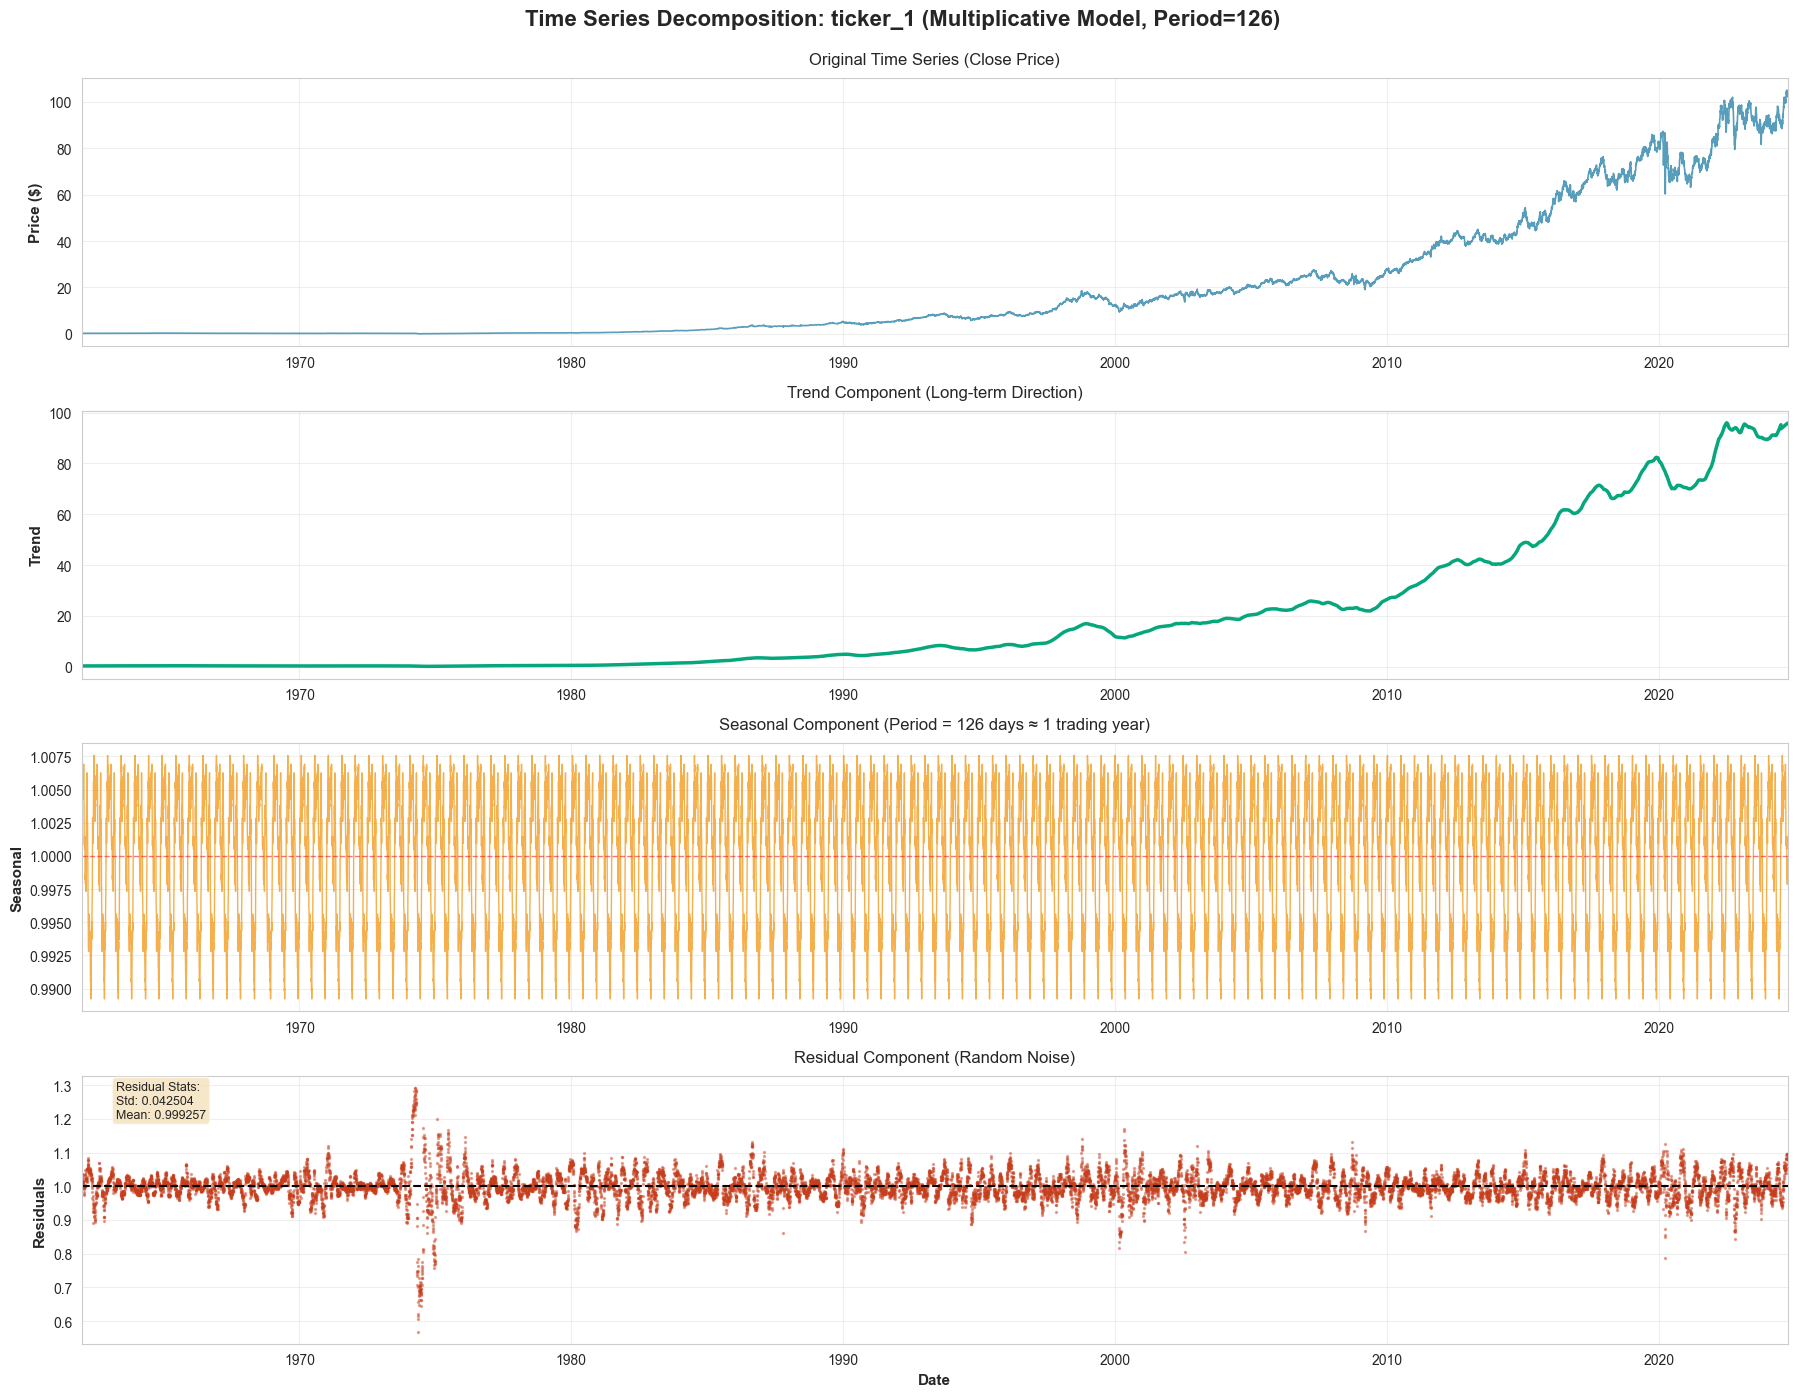


Analyzing: ticker_4938


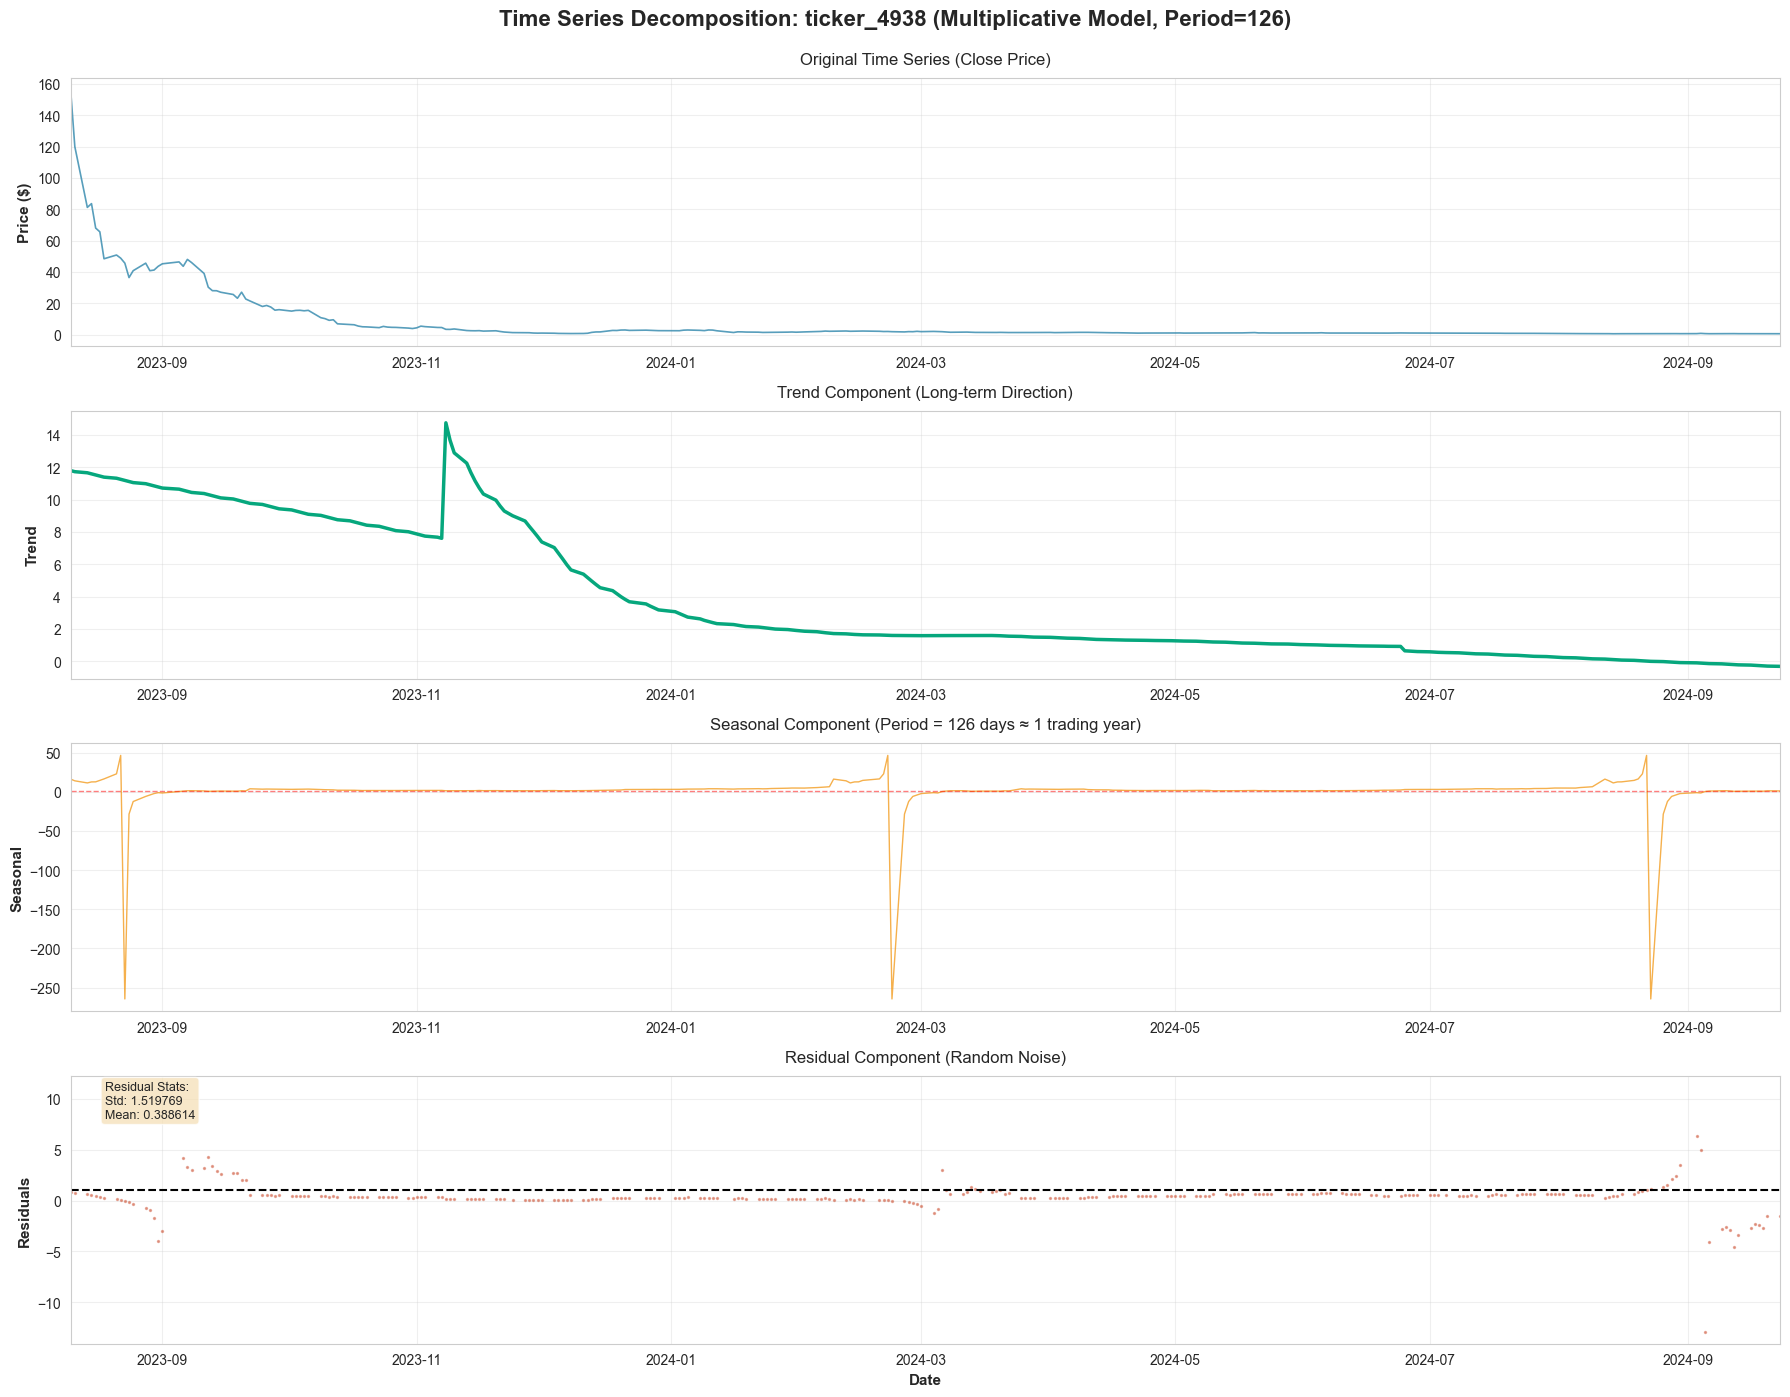


Analyzing: ticker_4917


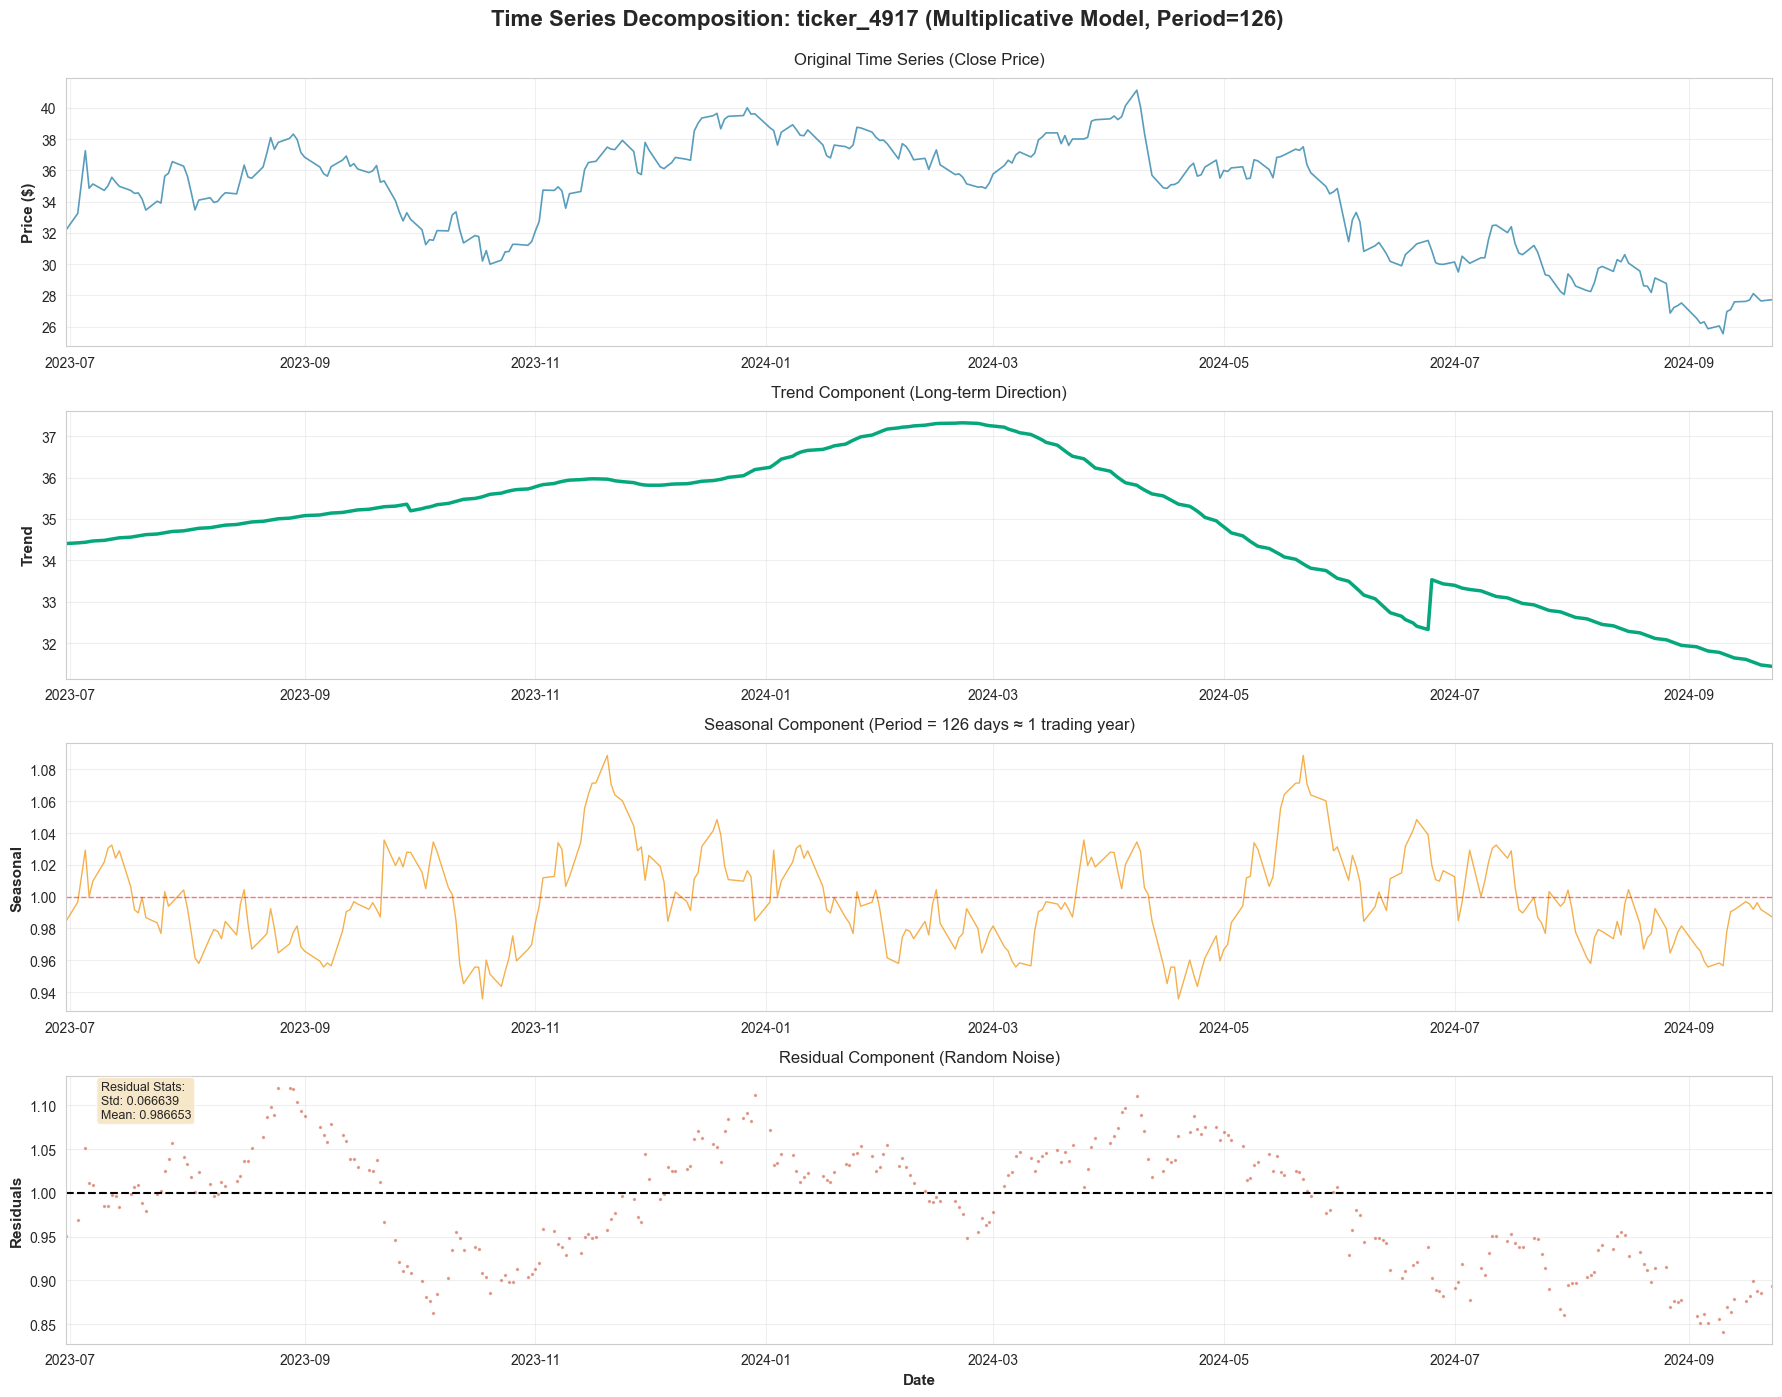


Analyzing: ticker_2617


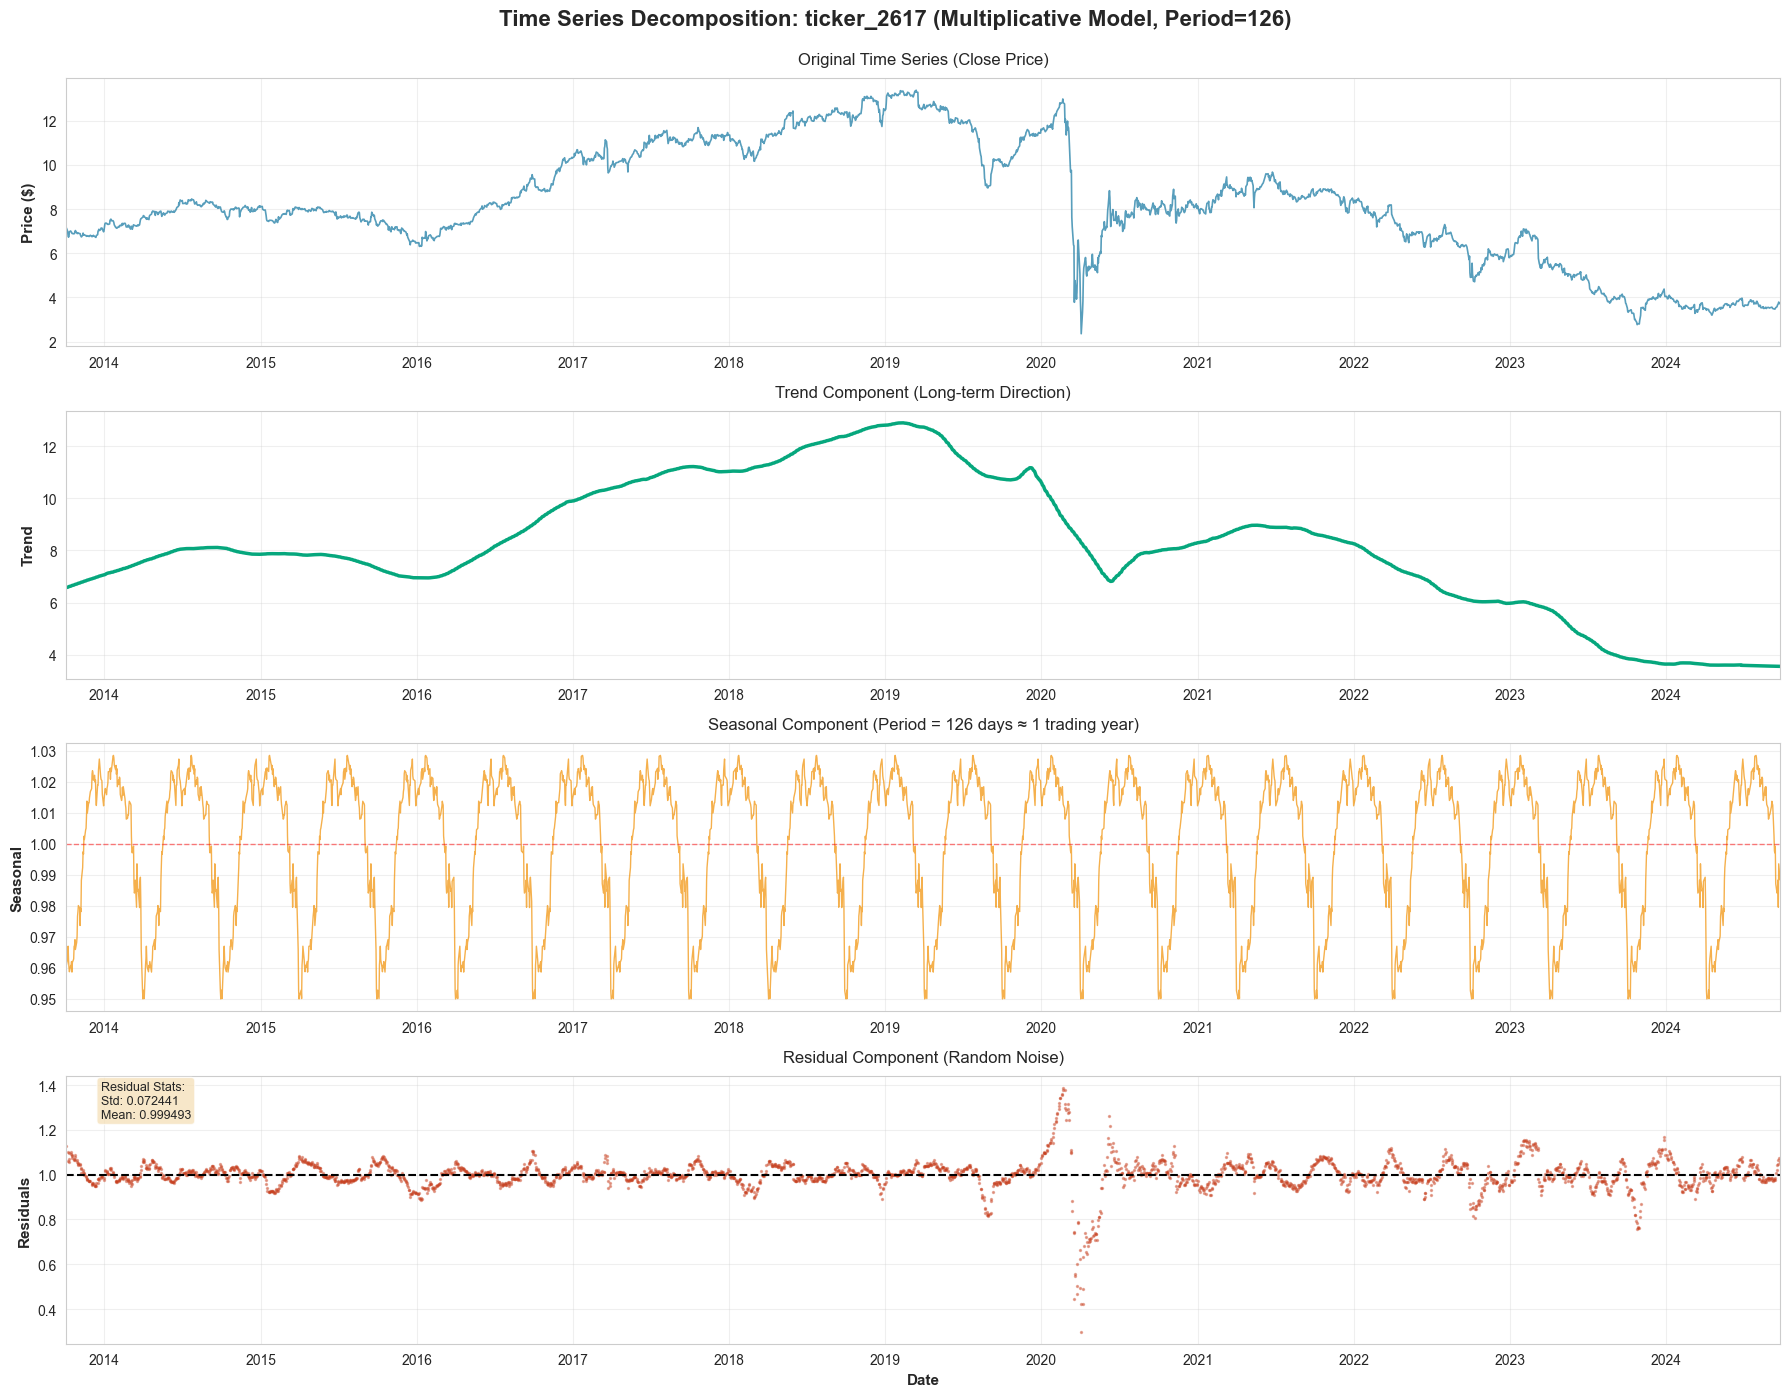

In [9]:
def decompose_stock(ticker, model='multiplicative', period=252):
    """
    Apply time series decomposition to a stock

    Parameters:
    -----------
    ticker : str
        Stock symbol
    model : str
        'additive' or 'multiplicative'
    period : int
        Seasonal period (252 = one trading year)
    """
    # Extract stock data
    stock_data = df[df['Ticker'] == ticker].copy()
    stock_data = stock_data.set_index('Date').sort_index()
    ts = stock_data['Close']

    # Apply decomposition
    decomposition = seasonal_decompose(
        ts,
        model=model,
        period=period,
        extrapolate_trend='freq'
    )

    # Plot components
    fig, axes = plt.subplots(4, 1, figsize=(18, 14))
    fig.suptitle(f'Time Series Decomposition: {ticker} ({model.title()} Model, Period={period})',
                 fontsize=16, fontweight='bold', y=0.995)

    # Original series
    axes[0].plot(ts.index, ts.values, color='#2E86AB', linewidth=1.2, alpha=0.8)
    axes[0].set_ylabel('Price ($)', fontweight='bold', fontsize=11)
    axes[0].set_title('Original Time Series (Close Price)', fontsize=12, pad=10)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim(ts.index.min(), ts.index.max())

    # Trend component
    axes[1].plot(decomposition.trend.index, decomposition.trend.values,
                color='#06A77D', linewidth=2.5)
    axes[1].set_ylabel('Trend', fontweight='bold', fontsize=11)
    axes[1].set_title('Trend Component (Long-term Direction)', fontsize=12, pad=10)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim(ts.index.min(), ts.index.max())

    # Seasonal component
    axes[2].plot(decomposition.seasonal.index, decomposition.seasonal.values,
                color='#F18F01', linewidth=1, alpha=0.7)
    axes[2].set_ylabel('Seasonal', fontweight='bold', fontsize=11)
    axes[2].set_title(f'Seasonal Component (Period = {period} days ≈ 1/2 trading year)', fontsize=12, pad=10)
    axes[2].grid(True, alpha=0.3)
    axes[2].axhline(y=1 if model=='multiplicative' else 0,
                   color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[2].set_xlim(ts.index.min(), ts.index.max())

    # Residual component
    axes[3].scatter(decomposition.resid.index, decomposition.resid.values,
                   alpha=0.4, s=2, color='#C73E1D')
    axes[3].axhline(y=1 if model=='multiplicative' else 0,
                   color='black', linestyle='--', linewidth=1.5)
    axes[3].set_ylabel('Residuals', fontweight='bold', fontsize=11)
    axes[3].set_xlabel('Date', fontweight='bold', fontsize=11)
    axes[3].set_title('Residual Component (Random Noise)', fontsize=12, pad=10)
    axes[3].grid(True, alpha=0.3)
    axes[3].set_xlim(ts.index.min(), ts.index.max())

    # Add statistics
    resid_clean = decomposition.resid.dropna()
    stats_text = f'Residual Stats:\nStd: {resid_clean.std():.6f}\nMean: {resid_clean.mean():.6f}'
    axes[3].text(0.02, 0.98, stats_text,
                transform=axes[3].transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7),
                fontsize=9)

    plt.tight_layout()
    plt.show()

    return decomposition, stock_data

# Apply decomposition to all selected stocks
print("\n" + "="*80)
print("QUESTION 1: DECOMPOSITION RESULTS")
print("="*80)

decompositions = {}
for ticker in selected_tickers:
    print(f"\n{'='*80}")
    print(f"Analyzing: {ticker}")
    print('='*80)

    decomp, stock_data = decompose_stock(ticker, model='multiplicative', period=126)
    decompositions[ticker] = {
        'decomposition': decomp,
        'data': stock_data,
        'model': 'multiplicative'
    }


## 1. مقارنة الاتجاه العام (Trend) بين الأسهم
يختلف الاتجاه العام لكل سهم بناءً على عمره في السوق وأدائه التاريخي:

*   **الاتجاه الصاعد المستمر (`ticker_1`)**: يمتد لأكثر من 60 عاماً، وهو نموذج للنمو طويل الأمد (Long-term behavior).
*   **الاتجاه الهابط الحاد (`ticker_4938`)**: سهم حديث نسبياً أظهر انخفاضاً مستمراً من سعر `$140` إلى ما يقارب الصفر، مما يجعله مثالاً على التذبذب العالي جداً (`236.32%` CV).
*   **الاتجاه المتذبذب (`ticker_2617`)**: يظهر دورة كاملة من الصعود (`2014-2019`) ثم الهبوط، مما يساعد في دراسة **"التقلبات الدورية" (Cyclical Fluctuations)**.

---

## 2. تحليل الأنماط الموسمية (Seasonality)
بما أنك قمت بضبط الفترة على 126 يوم تداول (حوالي نصف سنة تجارية)، نلاحظ ما يلي:

*   **الانتظام**: يظهر سهم `ticker_1` و `ticker_2617` أنماطاً موسمية ثابتة ومنتظمة جداً.
*   **القيم المتطرفة**: في سهم `ticker_4938`، المكون الموسمي يظهر تشوهات كبيرة (هبوط مفاجئ تحت الصفر)، وهذا غالباً ما يكون نتيجة **"تجزئة السهم" (Stock Splits)** أو توزيعات أرباح ضخمة، وهي بيانات يجب معالجتها قبل تدريب الشبكة العصبونية.
*   **التكرار**: الأنماط الموسمية تساعد الشبكة العصبونية في تعلم **"سلوك متكرر مرتبط بفترات زمنية معينة"**.

---

## 3. البقايا (Residuals) والأنماط قصيرة المدى
تعد البقايا مفتاحاً لاستخراج **"الأنماط المحلية" (Local Patterns)**:

*   **العشوائية النسبية**: سهم `ticker_1` يمتلك بقايا مستقرة نسبياً حول المتوسط، مما يعني أن معظم حركته يمكن تفسيرها بالاتجاه والموسمية.
*   **الصدمات المفاجئة**: في سهم `ticker_2617`، نلاحظ قفزة هائلة في البقايا عام `2020` (أزمة كورونا)، وهو ما يمثل **"التغيرات غير المنتظمة"** الناجمة عن أحداث عشوائية لا يمكن التنبؤ بها.
*   **الضجيج العالي**: سهم `ticker_4938` يمتلك بقايا غير مستقرة (`Std: 1.51`)، مما يصعّب مهمة التنبؤ ويجعل الشبكة العصبونية عرضة للخطأ إذا لم تُستخدم تقنيات تدريب مناسبة.

# السؤال الثاني: هل توجد أنماط موسمية واضحة؟

In [10]:
def analyze_seasonal_patterns(ticker):
    """
    Analyze seasonal patterns at different time scales
    """
    stock_data = df[df['Ticker'] == ticker].copy()
    stock_data = stock_data.sort_values('Date')

    # Add calendar features
    stock_data['Year'] = stock_data['Date'].dt.year
    stock_data['Month'] = stock_data['Date'].dt.month
    stock_data['Quarter'] = stock_data['Date'].dt.quarter
    stock_data['DayOfWeek'] = stock_data['Date'].dt.dayofweek
    stock_data['WeekOfYear'] = stock_data['Date'].dt.isocalendar().week

    # Calculate daily returns
    stock_data['Daily_Return'] = stock_data['Close'].pct_change() * 100

    # Monthly statistics
    monthly_stats = stock_data.groupby('Month')['Daily_Return'].agg([
        'mean', 'median', 'std', 'count'
    ]).reset_index()

    # Quarterly statistics
    quarterly_stats = stock_data.groupby('Quarter')['Daily_Return'].agg([
        'mean', 'median', 'std', 'count'
    ]).reset_index()

    # Weekly statistics (day of week)
    weekly_stats = stock_data.groupby('DayOfWeek')['Daily_Return'].agg([
        'mean', 'median', 'std', 'count'
    ]).reset_index()

    return monthly_stats, quarterly_stats, weekly_stats, stock_data

# Analyze all selected stocks
print("\n" + "="*80)
print("QUESTION 2: SEASONAL PATTERNS ANALYSIS")
print("="*80)

seasonal_results = {}
for ticker in selected_tickers:
    monthly, quarterly, weekly, data = analyze_seasonal_patterns(ticker)
    seasonal_results[ticker] = {
        'monthly': monthly,
        'quarterly': quarterly,
        'weekly': weekly,
        'data': data
    }


QUESTION 2: SEASONAL PATTERNS ANALYSIS



### Visualizing Seasonal Patterns - Individual Stocks

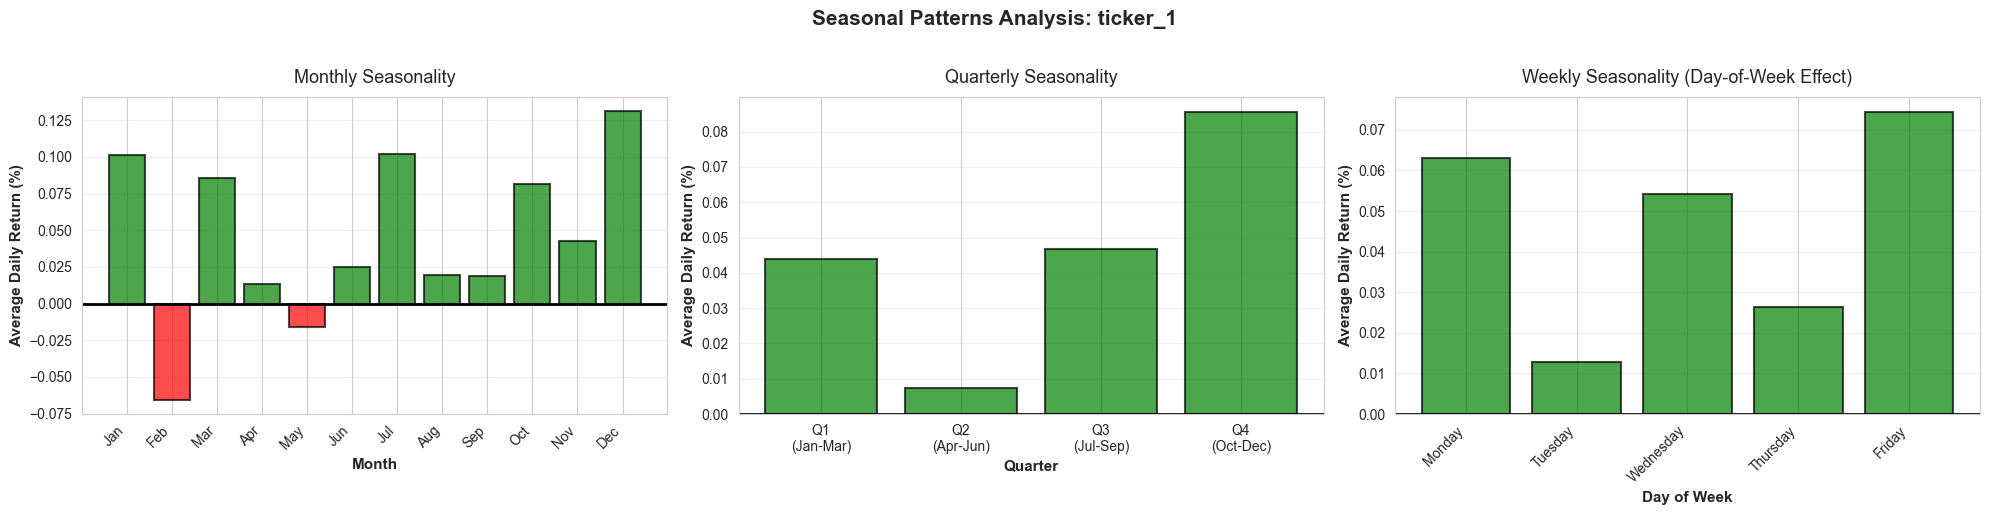


ticker_1 - Seasonal Pattern Statistics:
--------------------------------------------------------------------------------

Monthly:
 Month      mean  median      std  count
     1  0.101305     0.0 1.301426   1312
     2 -0.065419     0.0 1.067870   1206
     3  0.085319     0.0 1.377143   1377
     4  0.013498     0.0 1.464676   1302
     5 -0.015822     0.0 1.341475   1334
     6  0.024809     0.0 1.102677   1342
     7  0.101907     0.0 1.227486   1325
     8  0.019374     0.0 1.118859   1392
     9  0.018928     0.0 1.144701   1273
    10  0.081549     0.0 1.456160   1365
    11  0.042624     0.0 1.157116   1255
    12  0.131067     0.0 1.089459   1305

Quarterly:
 Quarter     mean  median      std  count
       1 0.044031     0.0 1.264392   3895
       2 0.007482     0.0 1.309671   3978
       3 0.046639     0.0 1.164468   3990
       4 0.085567     0.0 1.249262   3925

Weekly:
 DayOfWeek     mean  median      std  count
         0 0.063010     0.0 1.265732   3008
         1 0.012

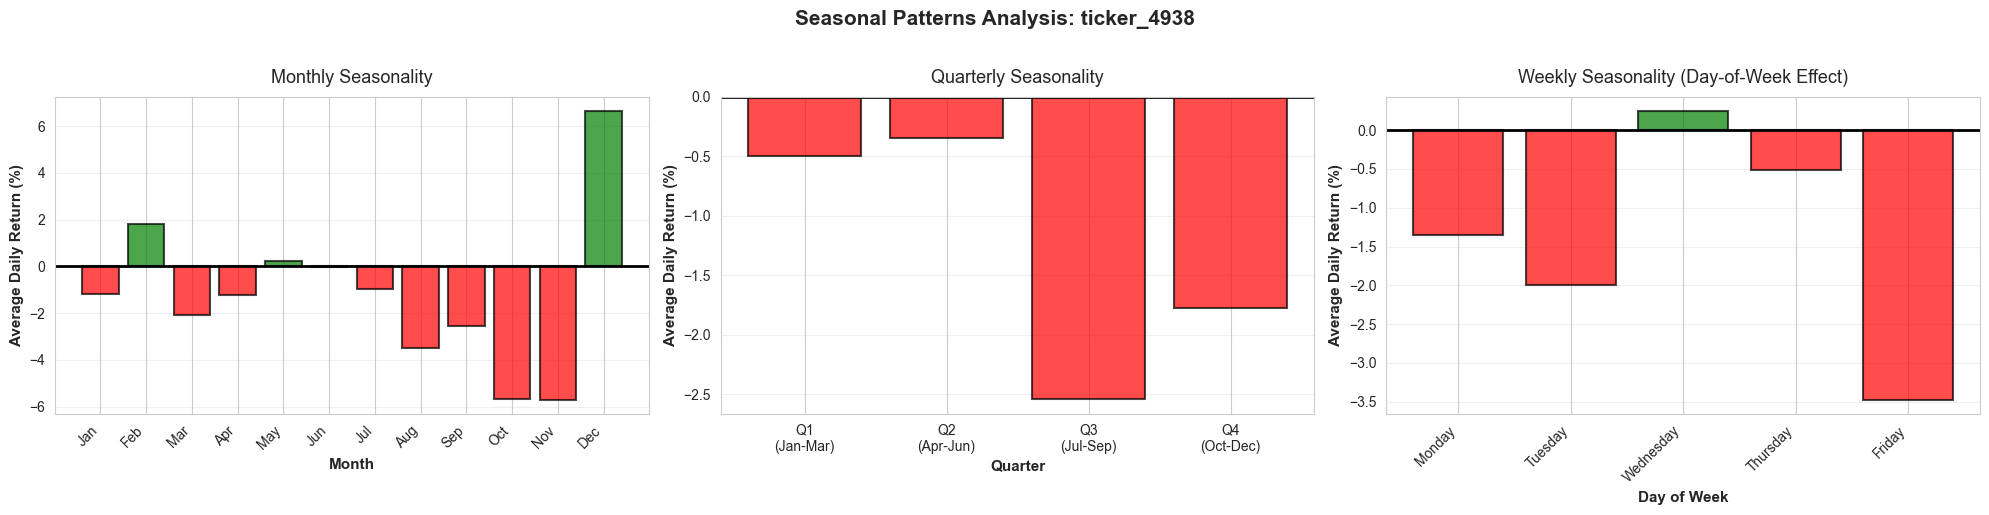


ticker_4938 - Seasonal Pattern Statistics:
--------------------------------------------------------------------------------

Monthly:
 Month      mean    median       std  count
     1 -1.179720 -1.503718 14.509306     21
     2  1.810642  1.564959  7.212632     20
     3 -2.077731 -2.639975  5.133663     20
     4 -1.221571 -0.719424  4.705510     22
     5  0.227807  0.490196  6.734222     22
     6 -0.007246 -0.990098  5.695450     19
     7 -0.985508 -0.524481  3.294809     22
     8 -3.469518 -2.647060 10.164638     37
     9 -2.530001 -2.539678  9.894043     35
    10 -5.681506 -5.667227  9.985063     22
    11 -5.695090 -5.925929 13.126462     21
    12  6.634792  0.105089 20.460300     20

Quarterly:
 Quarter      mean    median       std  count
       1 -0.493703 -1.063838  9.887551     61
       2 -0.349214  0.000000  5.718531     63
       3 -2.538334 -1.927277  8.896629     94
       4 -1.776098 -3.333340 15.845323     63

Weekly:
 DayOfWeek      mean    median       std  

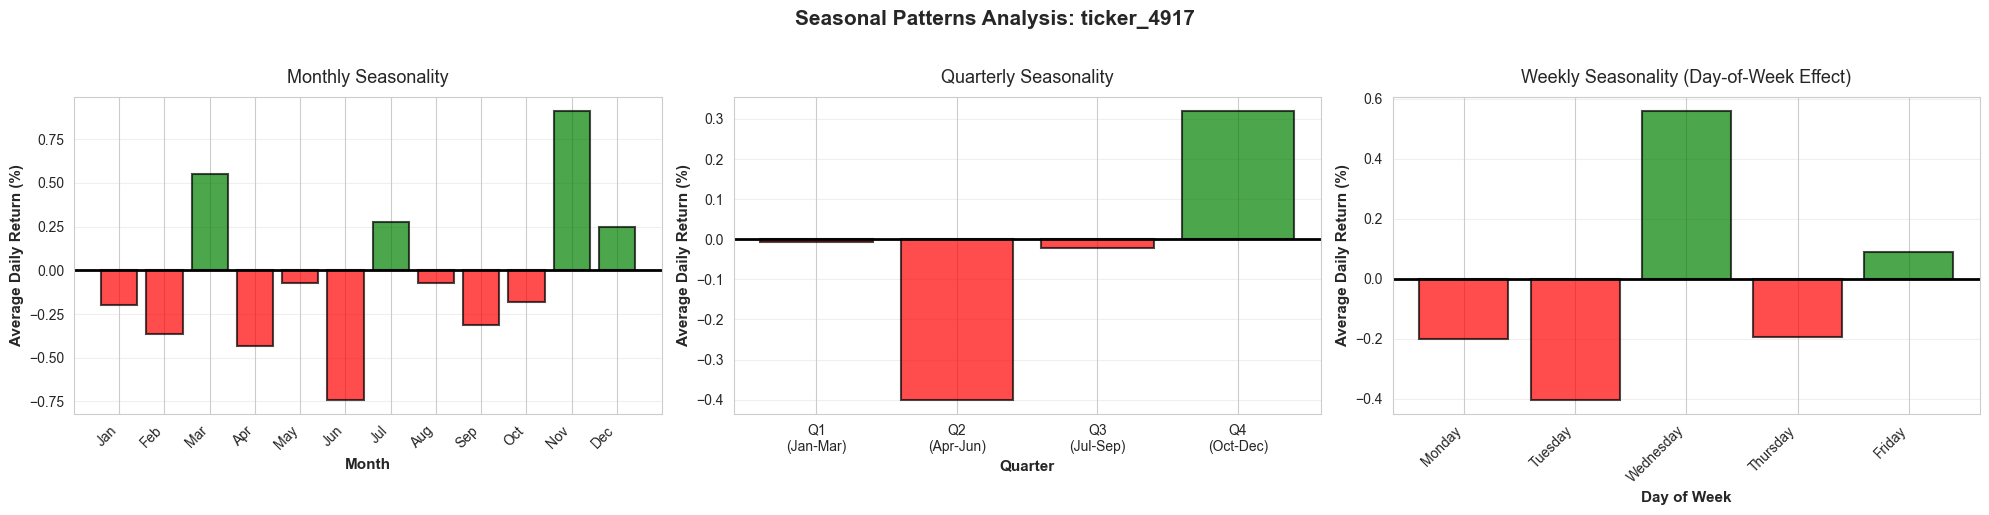


ticker_4917 - Seasonal Pattern Statistics:
--------------------------------------------------------------------------------

Monthly:
 Month      mean    median      std  count
     1 -0.197976 -0.378991 1.496480     21
     2 -0.363665 -0.537467 1.393141     20
     3  0.552657  0.582378 1.171351     20
     4 -0.432750  0.202748 2.048835     22
     5 -0.073627  0.124281 1.647856     22
     6 -0.739391 -0.332227 3.076911     19
     7  0.274220 -0.265129 2.937461     42
     8 -0.072345 -0.104824 2.027077     45
     9 -0.311841 -0.447052 1.753119     35
    10 -0.180715  0.032476 2.098974     22
    11  0.908990  0.405689 2.490419     21
    12  0.249307  0.380475 1.635500     20

Quarterly:
 Quarter      mean    median      std  count
       1 -0.006191 -0.078428 1.398265     61
       2 -0.399821  0.112806 2.272361     63
       3 -0.021744 -0.203562 2.310254    122
       4  0.319035  0.379751 2.126205     63

Weekly:
 DayOfWeek      mean    median      std  count
         0 -0

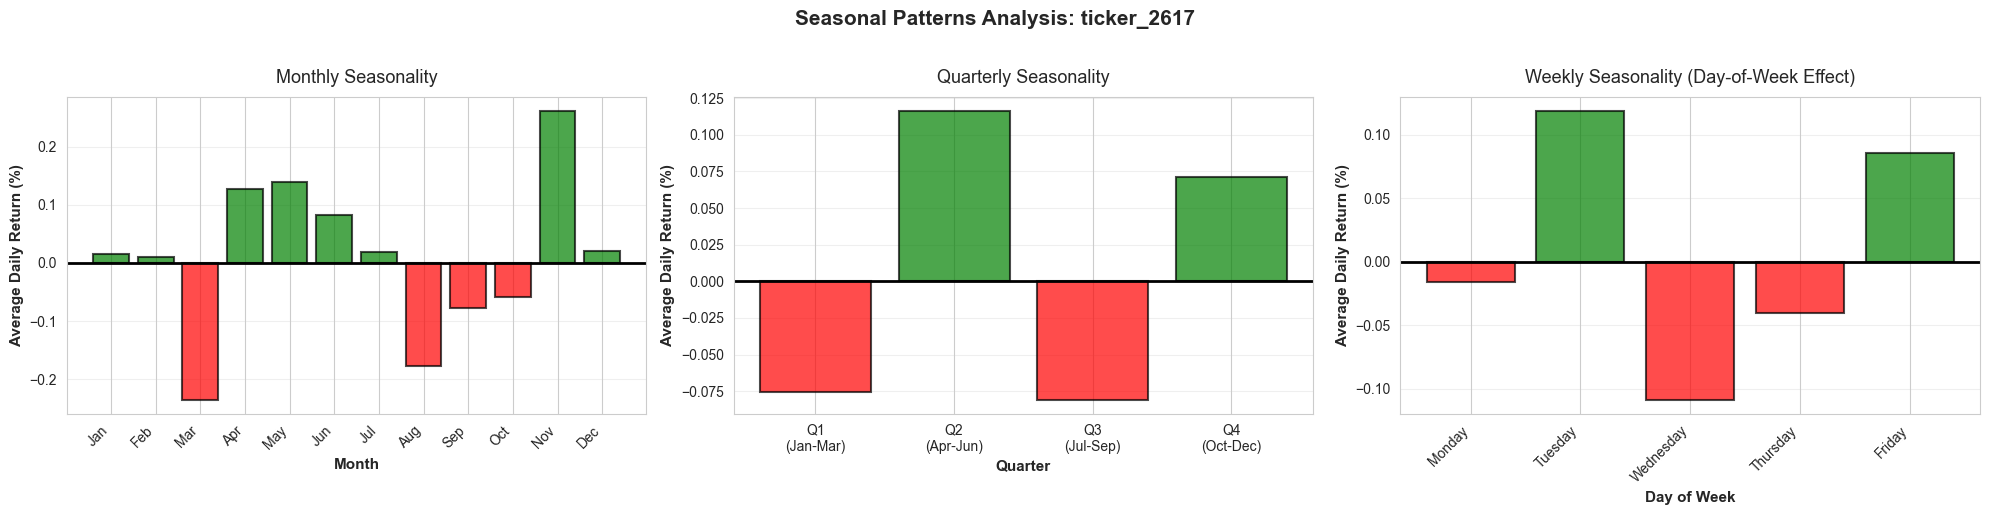


ticker_2617 - Seasonal Pattern Statistics:
--------------------------------------------------------------------------------

Monthly:
 Month      mean    median      std  count
     1  0.015516 -0.053905 1.433369    223
     2  0.010839  0.055627 1.402170    211
     3 -0.235301  0.109599 4.988898    241
     4  0.126440  0.000000 4.750218    227
     5  0.139938  0.069481 2.126539    233
     6  0.081946  0.108505 1.990279    233
     7  0.018741  0.000000 1.330880    232
     8 -0.177975 -0.106382 1.295783    244
     9 -0.077893 -0.025087 1.578861    220
    10 -0.059263 -0.061344 1.753102    239
    11  0.260987  0.106655 1.881639    225
    12  0.020855  0.068411 1.406625    231

Quarterly:
 Quarter      mean   median      std  count
       1 -0.075497 0.053202 3.188431    675
       2  0.116018 0.060758 3.195952    693
       3 -0.080768 0.000000 1.402821    696
       4  0.071044 0.053861 1.694363    695

Weekly:
 DayOfWeek      mean   median      std  count
         0 -0.01618

In [11]:

for ticker in selected_tickers:
    monthly_stats = seasonal_results[ticker]['monthly']
    quarterly_stats = seasonal_results[ticker]['quarterly']
    weekly_stats = seasonal_results[ticker]['weekly']

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(f'Seasonal Patterns Analysis: {ticker}',
                 fontsize=15, fontweight='bold', y=1.02)

    # Monthly patterns
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    colors_m = ['green' if x > 0 else 'red' for x in monthly_stats['mean']]
    bars_m = axes[0].bar(monthly_stats['Month'], monthly_stats['mean'],
                         color=colors_m, edgecolor='black', alpha=0.7, linewidth=1.5)
    axes[0].axhline(y=0, color='black', linestyle='-', linewidth=2)
    axes[0].set_xlabel('Month', fontweight='bold', fontsize=11)
    axes[0].set_ylabel('Average Daily Return (%)', fontweight='bold', fontsize=11)
    axes[0].set_title('Monthly Seasonality', fontsize=13, pad=10)
    axes[0].set_xticks(range(1, 13))
    axes[0].set_xticklabels(month_names, rotation=45, ha='right')
    axes[0].grid(True, alpha=0.3, axis='y')

    # Quarterly patterns
    quarter_names = ['Q1\n(Jan-Mar)', 'Q2\n(Apr-Jun)', 'Q3\n(Jul-Sep)', 'Q4\n(Oct-Dec)']
    colors_q = ['green' if x > 0 else 'red' for x in quarterly_stats['mean']]
    bars_q = axes[1].bar(quarterly_stats['Quarter'], quarterly_stats['mean'],
                         color=colors_q, edgecolor='black', alpha=0.7, linewidth=1.5)
    axes[1].axhline(y=0, color='black', linestyle='-', linewidth=2)
    axes[1].set_xlabel('Quarter', fontweight='bold', fontsize=11)
    axes[1].set_ylabel('Average Daily Return (%)', fontweight='bold', fontsize=11)
    axes[1].set_title('Quarterly Seasonality', fontsize=13, pad=10)
    axes[1].set_xticks(range(1, 5))
    axes[1].set_xticklabels(quarter_names)
    axes[1].grid(True, alpha=0.3, axis='y')

    # Weekly patterns
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    colors_w = ['green' if x > 0 else 'red' for x in weekly_stats['mean']]
    bars_w = axes[2].bar(weekly_stats['DayOfWeek'], weekly_stats['mean'],
                         color=colors_w, edgecolor='black', alpha=0.7, linewidth=1.5)
    axes[2].axhline(y=0, color='black', linestyle='-', linewidth=2)
    axes[2].set_xlabel('Day of Week', fontweight='bold', fontsize=11)
    axes[2].set_ylabel('Average Daily Return (%)', fontweight='bold', fontsize=11)
    axes[2].set_title('Weekly Seasonality (Day-of-Week Effect)', fontsize=13, pad=10)
    axes[2].set_xticks(range(5))
    axes[2].set_xticklabels(day_names, rotation=45, ha='right')
    axes[2].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"\n{ticker} - Seasonal Pattern Statistics:")
    print("-" * 80)
    print("\nMonthly:")
    print(monthly_stats.to_string(index=False))
    print("\nQuarterly:")
    print(quarterly_stats.to_string(index=False))
    print("\nWeekly:")
    print(weekly_stats.to_string(index=False))

# استخلاص رؤى عملية لتصميم وتدريب الشبكات العصبونية

## 1. تحديد "النوافذ الزمنية" للتدريب (Sliding Windows)
أظهرت الرسوم البيانية أن الموسمية واضحة عند `126` و `252` يوم تداول.

*   **المستفاد**: عند تصميم الشبكة، يفضل أن يكون طول المدخلات (Sequence Length) متوافقاً مع هذه الدورات (مثلاً إدخال بيانات آخر `126` يوماً) لتمكين الشبكة من استخراج الأنماط المتكررة.

---

## 2. فهم "سلوك السهم" لتخصيص المعالجة
النتائج في الإحصائيات (Seasonal Pattern Statistics) تكشف عن فروق جوهرية بين الأسهم:

*   **`ticker_1` (الاستقرار)**: يظهر نمواً مستقراً مع انحراف معياري (`std`) منخفض في العوائد الشهرية (`~1.3`). هذا السهم يعلم الشبكة **السلوك طويل المدى**.
*   **`ticker_4938` (التذبذب العالي)**: يمتلك (`std`) ضخم يصل إلى `14.5` في بعض الأشهر، مع عوائد سالبة حادة في الربع الثالث (`-2.5%`). هذا السهم يدرب الشبكة على **الارتفاعات والانخفاضات المفاجئة والتغيرات غير المنتظمة**.

---

## 3. اكتشاف "التحيزات الزمنية" (Seasonality Analysis)
الرسوم البيانية للموسمية (`q-tic1.png` و `q-tic4.png`) تقدم ميزات (Features) قوية:

*   **تأثير يوم الأسبوع**: لاحظ في `ticker_1` أن يوم الجمعة (Friday) يمتلك أعلى متوسط عائد (`0.074%`).
*   **تأثير الربع السنوي**: الربع الرابع (`Q4`) في أغلب الأسهم المستقرة هو الأفضل أداءً.
*   **المستفاد**: يمكنك إضافة **"يوم الأسبوع"** أو **"الشهر"** كمدخلات إضافية (Categorical Embeddings) للشبكة لزيادة دقة التنبؤ.

---

## 4. التعامل مع "البقايا" (Residuals) كإشارة للضجيج
اللوحة الأخيرة في كل رسم بياني (Residual Component) توضح مقدار "العشوائية":

*   الأسهم التي تملك بقايا مشتتة جداً (مثل `ticker_4938`) تتطلب تقنيات تدريب مثل **Dropout** أو **Regularization** لمنع الشبكة من حفظ الضجيج (Overfitting) بدلاً من تعلم الأنماط.


### Aggregate Seasonal Patterns Across All Stocks

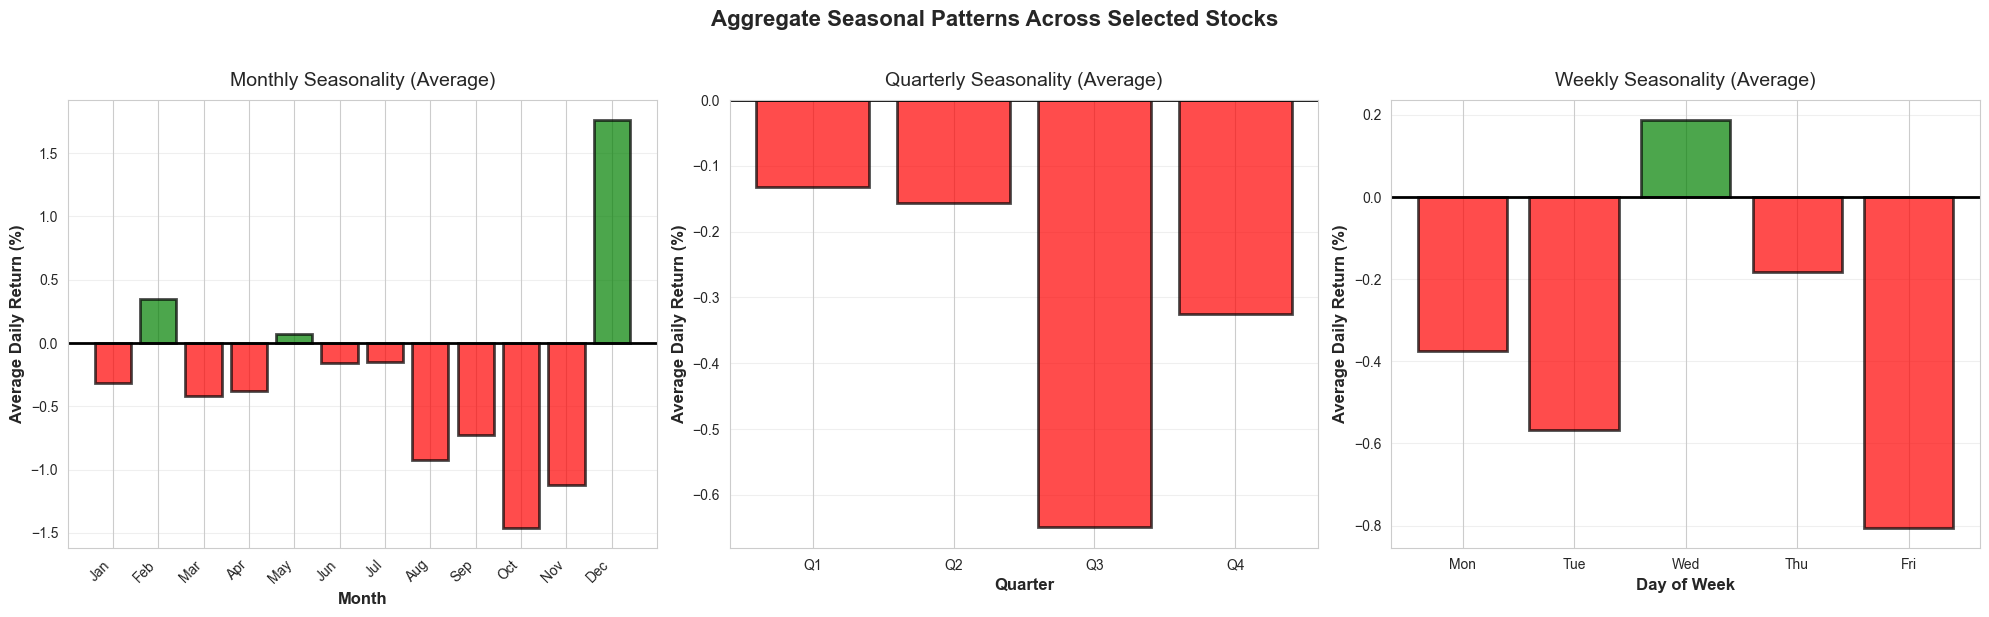

In [12]:

# Aggregate patterns across all stocks
all_monthly = []
all_quarterly = []
all_weekly = []

for ticker in selected_tickers:
    monthly_stats = seasonal_results[ticker]['monthly'].copy()
    quarterly_stats = seasonal_results[ticker]['quarterly'].copy()
    weekly_stats = seasonal_results[ticker]['weekly'].copy()

    monthly_stats['Ticker'] = ticker
    quarterly_stats['Ticker'] = ticker
    weekly_stats['Ticker'] = ticker

    all_monthly.append(monthly_stats)
    all_quarterly.append(quarterly_stats)
    all_weekly.append(weekly_stats)

all_monthly_df = pd.concat(all_monthly)
all_quarterly_df = pd.concat(all_quarterly)
all_weekly_df = pd.concat(all_weekly)

# Calculate averages
avg_monthly = all_monthly_df.groupby('Month')['mean'].mean().reset_index()
avg_quarterly = all_quarterly_df.groupby('Quarter')['mean'].mean().reset_index()
avg_weekly = all_weekly_df.groupby('DayOfWeek')['mean'].mean().reset_index()

# Plot aggregate patterns
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Aggregate Seasonal Patterns Across Selected Stocks',
             fontsize=16, fontweight='bold', y=1.02)

# Monthly
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
colors_m = ['green' if x > 0 else 'red' for x in avg_monthly['mean']]
axes[0].bar(avg_monthly['Month'], avg_monthly['mean'],
           color=colors_m, edgecolor='black', alpha=0.7, linewidth=2)
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=2)
axes[0].set_xlabel('Month', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Average Daily Return (%)', fontweight='bold', fontsize=12)
axes[0].set_title('Monthly Seasonality (Average)', fontsize=14, pad=10)
axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels(month_names, rotation=45, ha='right')
axes[0].grid(True, alpha=0.3, axis='y')

# Quarterly
quarter_names = ['Q1', 'Q2', 'Q3', 'Q4']
colors_q = ['green' if x > 0 else 'red' for x in avg_quarterly['mean']]
axes[1].bar(avg_quarterly['Quarter'], avg_quarterly['mean'],
           color=colors_q, edgecolor='black', alpha=0.7, linewidth=2)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=2)
axes[1].set_xlabel('Quarter', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Average Daily Return (%)', fontweight='bold', fontsize=12)
axes[1].set_title('Quarterly Seasonality (Average)', fontsize=14, pad=10)
axes[1].set_xticks(range(1, 5))
axes[1].set_xticklabels(quarter_names)
axes[1].grid(True, alpha=0.3, axis='y')

# Weekly
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
colors_w = ['green' if x > 0 else 'red' for x in avg_weekly['mean']]
axes[2].bar(avg_weekly['DayOfWeek'], avg_weekly['mean'],
           color=colors_w, edgecolor='black', alpha=0.7, linewidth=2)
axes[2].axhline(y=0, color='black', linestyle='-', linewidth=2)
axes[2].set_xlabel('Day of Week', fontweight='bold', fontsize=12)
axes[2].set_ylabel('Average Daily Return (%)', fontweight='bold', fontsize=12)
axes[2].set_title('Weekly Seasonality (Average)', fontsize=14, pad=10)
axes[2].set_xticks(range(5))
axes[2].set_xticklabels(day_names)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# مخططات الأنماط الموسمية (Seasonal Analysis)

## Monthly Seasonality
اكتشاف الأشهر التي يميل فيها السهم تاريخياً للصعود أو الهبوط (مثل طفرة ديسمبر).

## Quarterly Seasonality
رصد التأثيرات ربع السنوية المرتبطة بتقارير الأرباح أو الدورات الاقتصادية. (الربع الثالث)

## Weekly Seasonality
استخراج "الأنماط قصيرة المدى" المرتبطة بأيام الأسبوع (مثل تأثير يوم الجمعة والأربعاء).

### Seasonal Component Visualization

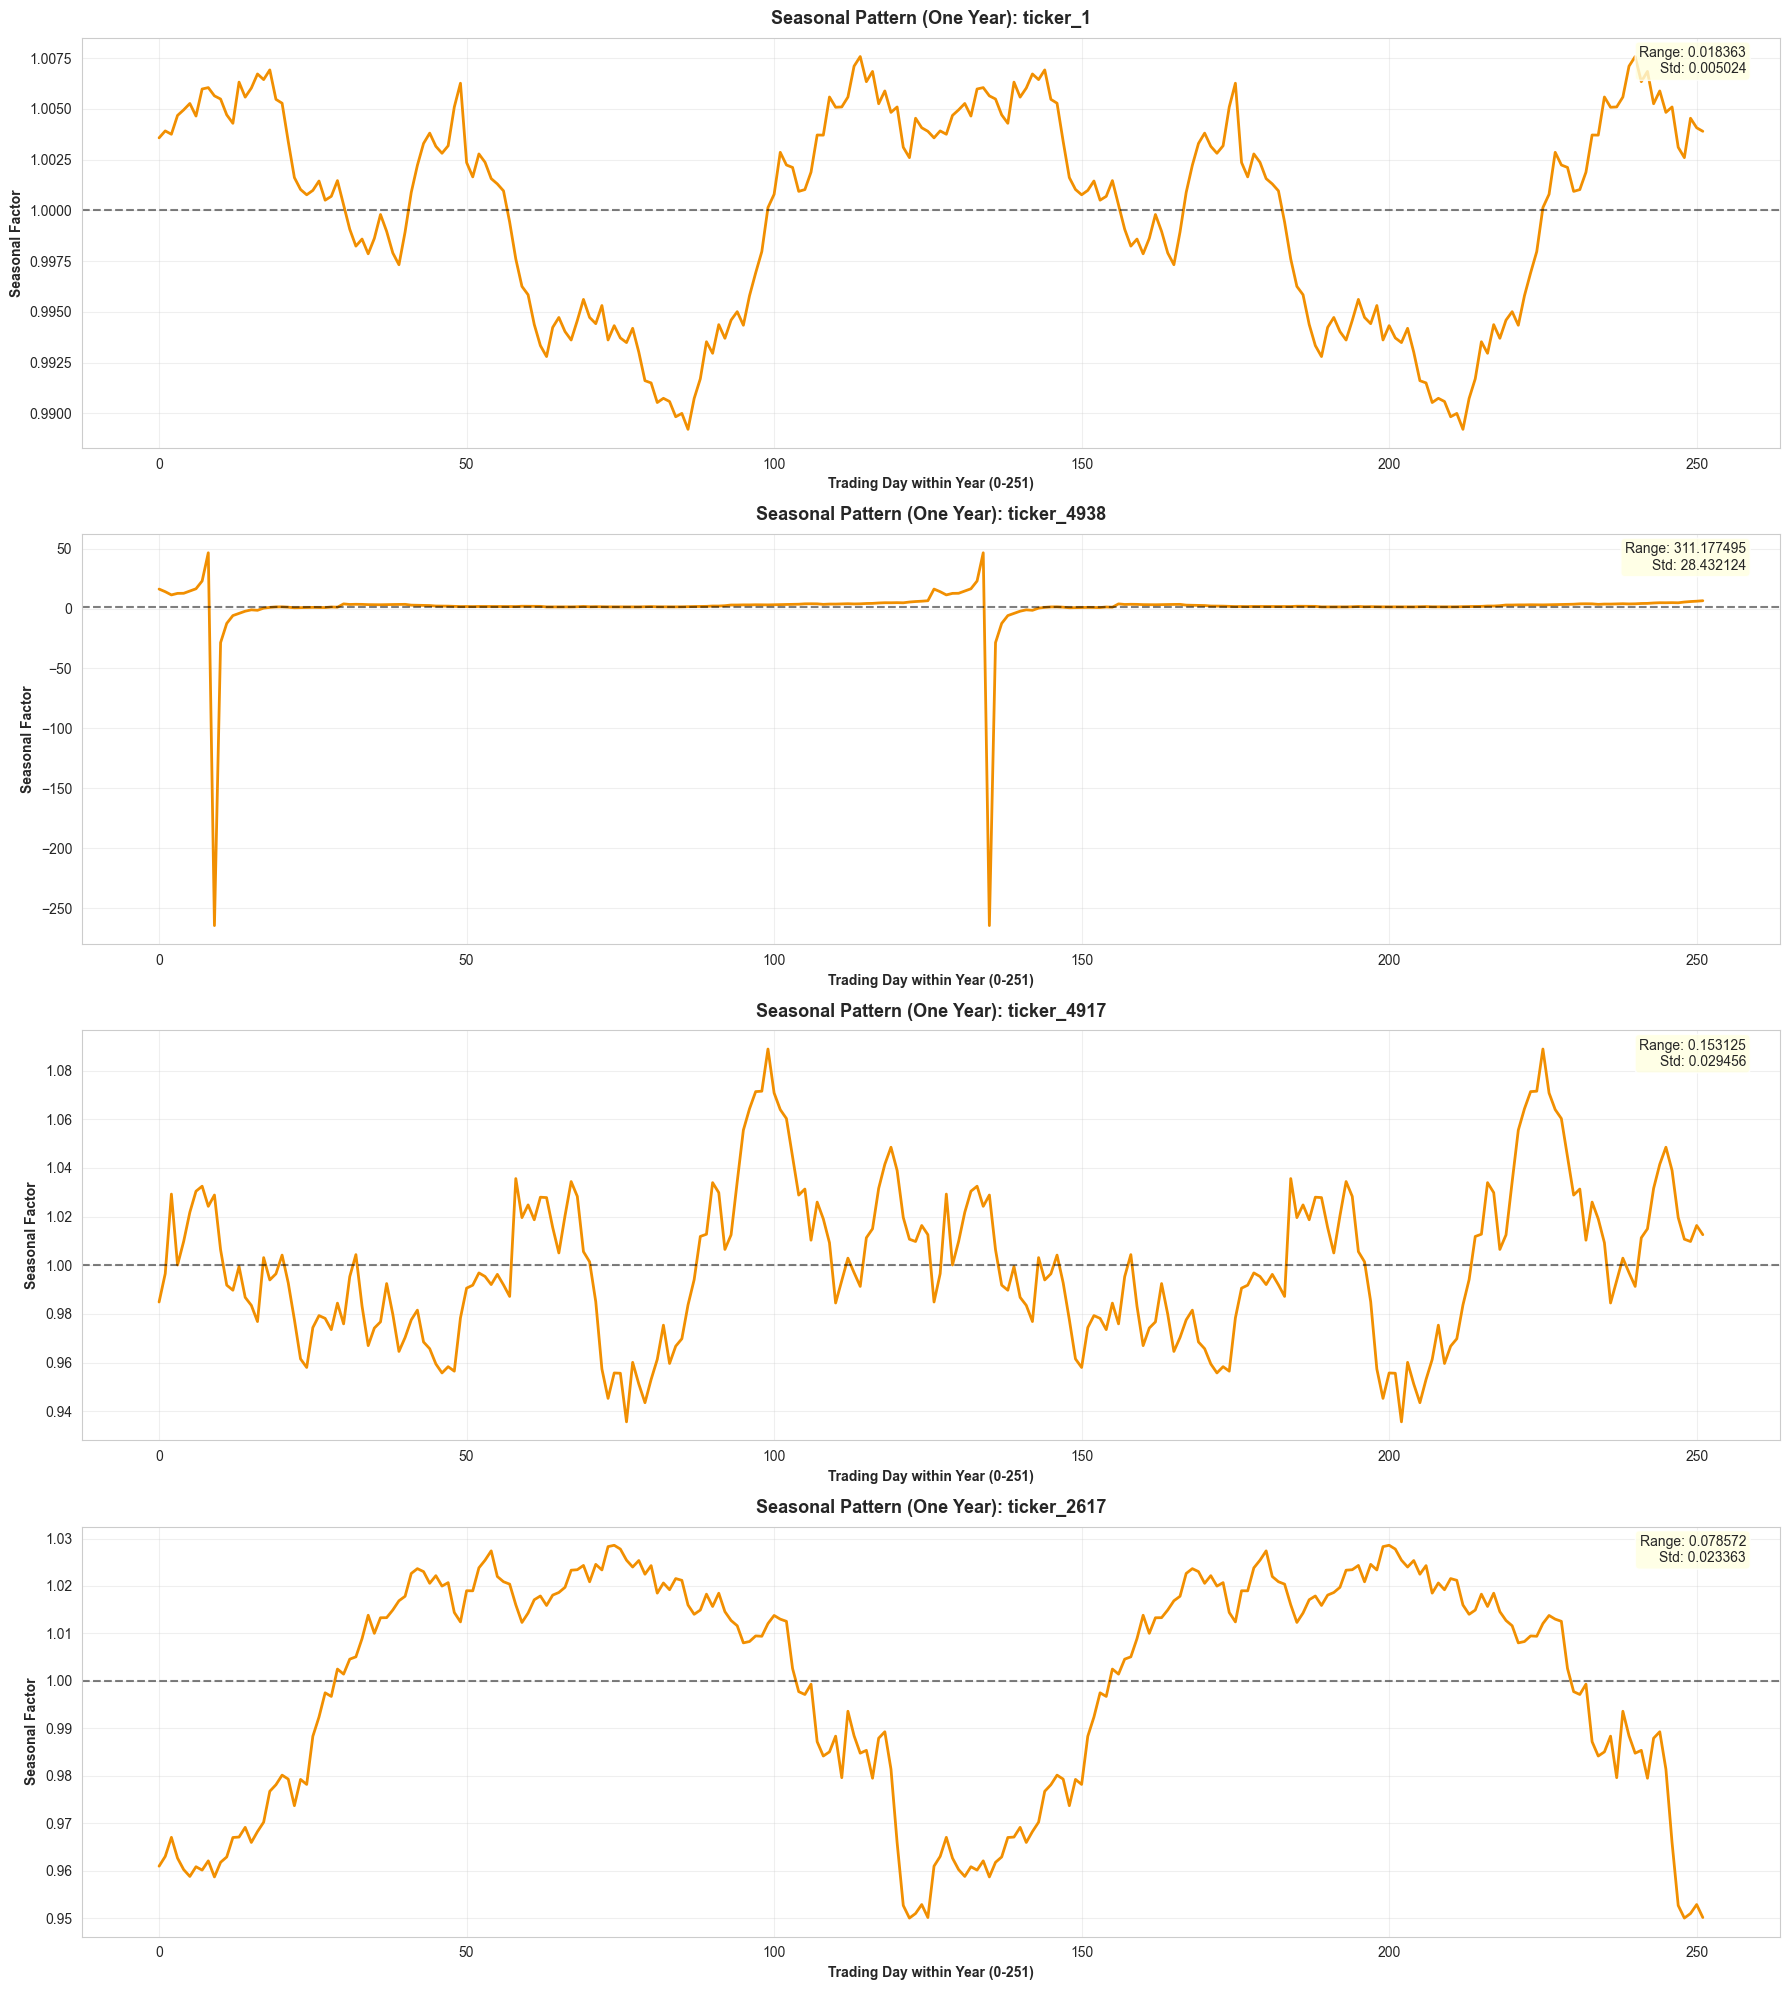

In [13]:

# Plot seasonal components from decomposition
fig, axes = plt.subplots(len(selected_tickers), 1,
                         figsize=(18, 5*len(selected_tickers)))

if len(selected_tickers) == 1:
    axes = [axes]

for idx, ticker in enumerate(selected_tickers):
    decomp = decompositions[ticker]['decomposition']
    seasonal = decomp.seasonal

    # Plot one year of seasonal pattern
    seasonal_one_period = seasonal.iloc[:252]

    axes[idx].plot(range(len(seasonal_one_period)), seasonal_one_period.values,
                   color='#F18F01', linewidth=2)
    axes[idx].axhline(y=1, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
    axes[idx].set_title(f'Seasonal Pattern (One Year): {ticker}',
                       fontsize=13, fontweight='bold', pad=10)
    axes[idx].set_xlabel('Trading Day within Year (0-251)', fontweight='bold')
    axes[idx].set_ylabel('Seasonal Factor', fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

    # Add statistics
    seasonal_clean = seasonal.dropna()
    stats_text = f'Range: {seasonal_clean.max() - seasonal_clean.min():.6f}\nStd: {seasonal_clean.std():.6f}'
    axes[idx].text(0.98, 0.98, stats_text,
                  transform=axes[idx].transAxes,
                  verticalalignment='top',
                  horizontalalignment='right',
                  bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8),
                  fontsize=10)

plt.tight_layout()
plt.show()

# مخطط النمط الموسمي لعام واحد (252 يوم تداول)

## 1. تحديد الدورات السنوية
توضح الصورة كيف يتصرف كل سهم خلال دورة 252 يوم تداول، مما يساعد الشبكة على تعلم **"الموسمية" (Seasonality)**.

## 2. قياس مدى التذبذب
يظهر الفرق الشاسع في المقياس (Scale) بين `ticker_1` المستقر و`ticker_4938` الذي يعاني من قفزات حادة، مما يستدعي **"تقييس البيانات" (Scaling)** قبل التدريب.

## 3. رصد النقاط الشاذة
تكشف الانخفاضات الحادة في `ticker_4938` عن **"تغيرات غير منتظمة" (Irregular Variations)** ناتجة عن أحداث مفاجئة كالأزمات أو الأخبار.

## 4. توقع نقاط الارتداد
تساعد القمم والقيعان المتكررة في المخطط الشبكة العصبونية على استخراج **"الأنماط قصيرة المدى" (Local Patterns)** للتنبؤ باتجاه الحركة.

## 5. تخصيص أوزان النموذج
المستفاد النهائي هو ضرورة تصميم شبكة مرنة تتعامل مع استقرار بعض الأسهم مقابل العشوائية العالية في أسهم أخرى لتحقيق أفضل **Score**.

# السؤال الثالث: ما هو الاتجاه العام لكل سهم (صاعد، هابط، مستقر)؟


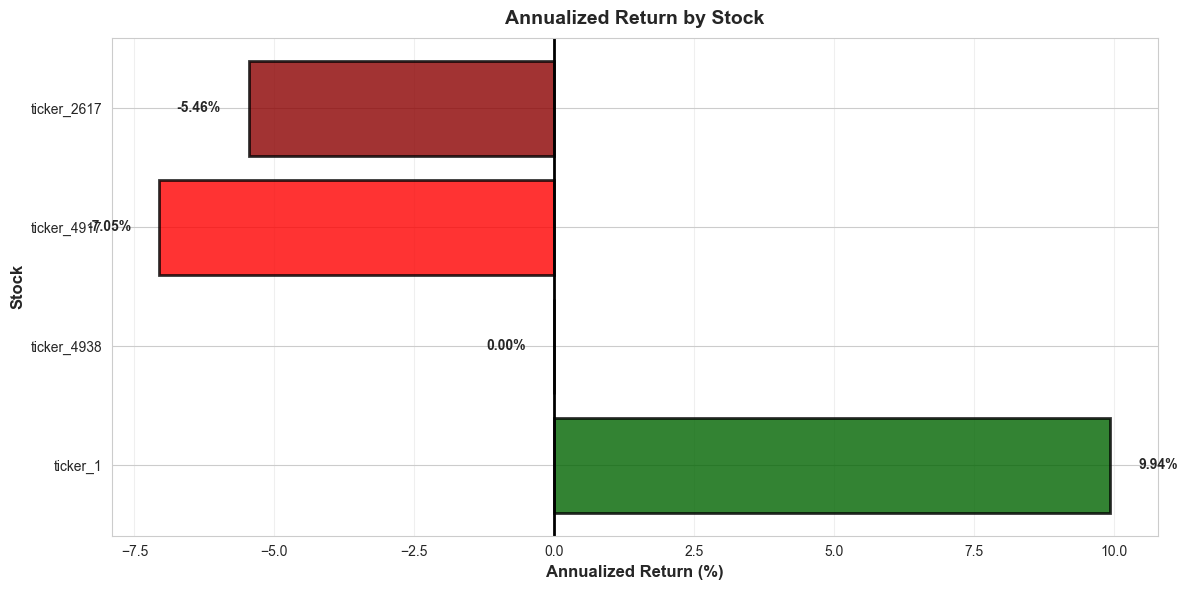

In [20]:
def classify_trend(decomposition, ticker, data):
    """
    Classify stock trend and calculate trend metrics
    """
    trend = decomposition.trend.dropna()

    # Basic metrics
    start_price = trend.iloc[0]
    end_price = trend.iloc[-1]
    total_change = ((end_price - start_price) / start_price) * 100

    # Time span
    years = (trend.index[-1] - trend.index[0]).days / 365.25

    # Annualized return
    if years > 0 and start_price > 0 and end_price > 0:
        annual_return = (((end_price / start_price) ** (1/years)) - 1) * 100
    else:
        annual_return = 0

    # Linear regression for trend slope
    x = np.arange(len(trend))
    y = trend.values
    slope, intercept, r_value, p_value, std_err = scipy_stats.linregress(x, y)

    # Annualized slope (convert from per-day to per-year)
    slope_annual = slope * 252

    # Trend classification
    if total_change > 20:
        direction = "Strong Uptrend ↗↗"
        color = 'darkgreen'
    elif total_change > 5:
        direction = "Moderate Uptrend ↗"
        color = 'green'
    elif total_change < -20:
        direction = "Strong Downtrend ↘↘"
        color = 'darkred'
    elif total_change < -5:
        direction = "Moderate Downtrend ↘"
        color = 'red'
    else:
        direction = "Stable/Sideways ➡"
        color = 'gray'

    return {
        'ticker': ticker,
        'direction': direction,
        'color': color,
        'total_change': total_change,
        'annual_return': annual_return,
        'start_price': start_price,
        'end_price': end_price,
        'years': years,
        'slope_annual': slope_annual,
        'r_squared': r_value**2,
        'p_value': p_value
    }

trend_analysis = []
for ticker in selected_tickers:
    analysis = classify_trend(
        decompositions[ticker]['decomposition'],
        ticker,
        decompositions[ticker]['data']
    )
    trend_analysis.append(analysis)

trend_df = pd.DataFrame(trend_analysis)

# Plot 1: Normalized trends (starting at 100)
for ticker in selected_tickers:
    trend = decompositions[ticker]['decomposition'].trend.dropna()
    normalized_trend = (trend / trend.iloc[0]) * 100

    # Get color from classification
    color = trend_df[trend_df['ticker'] == ticker]['color'].values[0]
    direction = trend_df[trend_df['ticker'] == ticker]['direction'].values[0]

    axes[0].plot(normalized_trend.index, normalized_trend.values,
                label=f'{ticker}: {direction}',
                linewidth=2.5, alpha=0.85, color=color)

axes[0].axhline(y=100, color='black', linestyle='--', linewidth=2, alpha=0.5)
axes[0].set_xlabel('Date', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Normalized Trend (Starting at 100)', fontweight='bold', fontsize=12)
axes[0].set_title('Trend Comparison: All Stocks (Normalized)',
                 fontsize=14, fontweight='bold', pad=15)
axes[0].legend(loc='best', fontsize=10, framealpha=0.9)
axes[0].grid(True, alpha=0.3)

# # Plot 2: Actual trends
# for ticker in selected_tickers:
#     trend = decompositions[ticker]['decomposition'].trend.dropna()
#     color = trend_df[trend_df['ticker'] == ticker]['color'].values[0]
#
#     axes[1].plot(trend.index, trend.values,
#                 label=ticker, linewidth=2.5, alpha=0.85, color=color)
#
# axes[1].set_xlabel('Date', fontweight='bold', fontsize=12)
# axes[1].set_ylabel('Trend (Actual Price $)', fontweight='bold', fontsize=12)
# axes[1].set_title('Trend Comparison: All Stocks (Actual Prices)',
#                  fontsize=14, fontweight='bold', pad=15)
# axes[1].legend(loc='best', fontsize=10, framealpha=0.9)
# axes[1].grid(True, alpha=0.3)
#
# plt.tight_layout()
# plt.show()

# Bar chart of returns
fig, ax = plt.subplots(figsize=(12, 6))
colors_bar = [trend_df[trend_df['ticker'] == t]['color'].values[0] for t in trend_df['ticker']]
bars = ax.barh(trend_df['ticker'], trend_df['annual_return'],
               color=colors_bar, edgecolor='black', linewidth=2, alpha=0.8)
ax.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax.set_xlabel('Annualized Return (%)', fontweight='bold', fontsize=12)
ax.set_ylabel('Stock', fontweight='bold', fontsize=12)
ax.set_title('Annualized Return by Stock', fontsize=14, fontweight='bold', pad=10)
ax.grid(True, alpha=0.3, axis='x')

for i, (bar, val) in enumerate(zip(bars, trend_df['annual_return'])):
    ax.text(val + (0.5 if val > 0 else -0.5), i, f'{val:.2f}%',
            va='center', ha='left' if val > 0 else 'right',
            fontweight='bold', fontsize=10)
plt.tight_layout()
plt.show()

# المستفاد من المخطط المكون الموسمي (Seasonal Factor)

## 1. تحديد التكرار الزمني
يساعد الشبكة العصبونية على تعلم الأنماط التي تتكرر مع الزمن (مثل القمم والقيعان السنوية) لدمجها كميزات تنبؤية.

## 2. كشف التذبذب (Volatility)
يوضح الفرق الهائل في الحجم بين `ticker_1` المستقر و`ticker_4938` المتقلب، مما ينبهك لضرورة استخدام تقنيات تدريب لمعالجة البيانات وتوحيد مقاييسها.

## 3. عزل الأحداث العشوائية
تظهر الانخفاضات الحادة المفاجئة (مثل التي في `ticker_4938`) كأحداث تندرج تحت **التغيرات غير المنتظمة** التي يجب على النموذج التمييز بينها وبين الاتجاه العام.

# السؤال الرابع: كيف تختلف مكونات التفكيك بين أسهم مختلفة؟


Component Statistics:
     Ticker  Trend_Mean  Trend_Std   Trend_CV  Seasonal_Range  Seasonal_Std  Residual_Mean  Residual_Std  Original_Mean  Original_Std
   ticker_1   19.468844  26.426856 135.739219        0.018363      0.005024       0.999257      0.042504      19.479645     26.500963
ticker_4938    3.797205   4.048189 106.609712      311.177495     28.432124       0.388614      1.519769       7.463663     17.638494
ticker_4917   34.879422   1.602743   4.595095        0.153125      0.029456       0.986653      0.066639      34.396677      3.544276
ticker_2617    8.260265   2.473447  29.943919        0.078572      0.023363       0.999493      0.072441       8.265485      2.576897


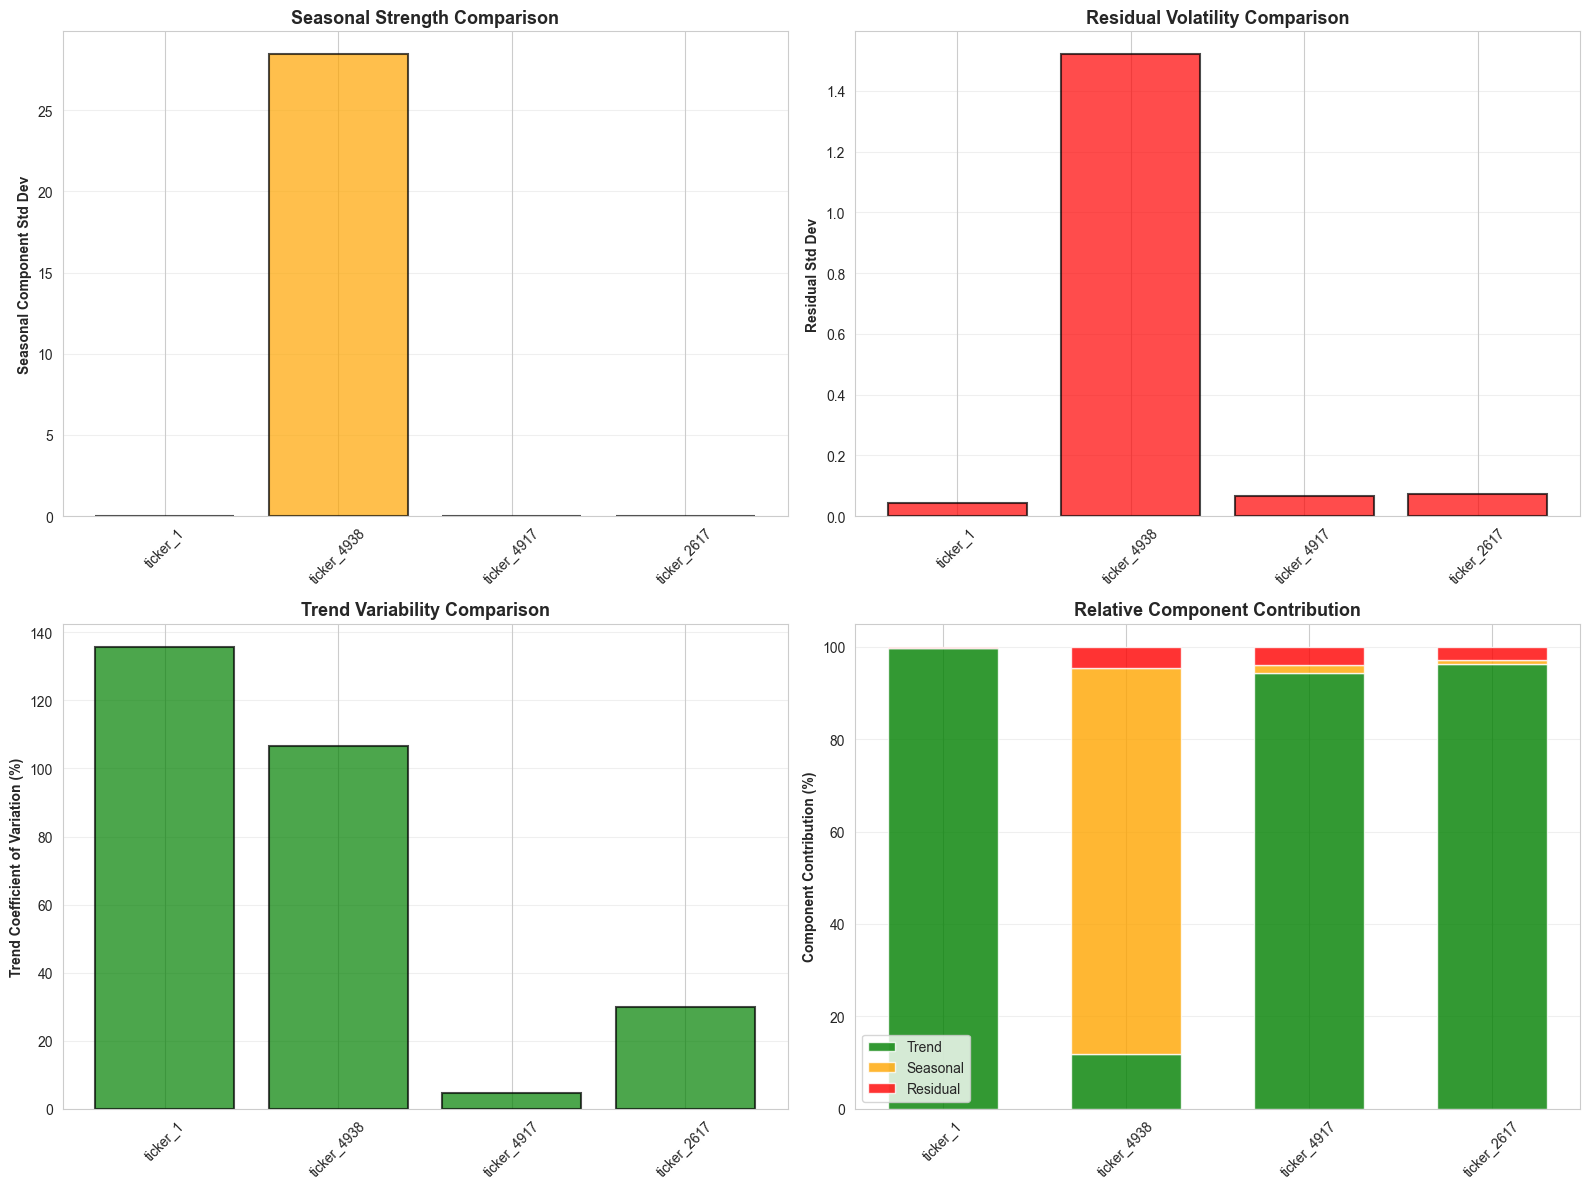

In [21]:
# Calculate component statistics
component_stats = []

for ticker in selected_tickers:
    decomp = decompositions[ticker]['decomposition']

    trend = decomp.trend.dropna()
    seasonal = decomp.seasonal.dropna()
    resid = decomp.resid.dropna()

    original = decompositions[ticker]['data']['Close']

    stats = {
        'Ticker': ticker,
        'Trend_Mean': trend.mean(),
        'Trend_Std': trend.std(),
        'Trend_CV': (trend.std() / trend.mean()) * 100,
        'Seasonal_Range': seasonal.max() - seasonal.min(),
        'Seasonal_Std': seasonal.std(),
        'Residual_Mean': resid.mean(),
        'Residual_Std': resid.std(),
        'Original_Mean': original.mean(),
        'Original_Std': original.std()
    }
    component_stats.append(stats)

comp_df = pd.DataFrame(component_stats)
print("\nComponent Statistics:")
print(comp_df.to_string(index=False))

# %%
# Visualization: Component comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Seasonal strength comparison
axes[0, 0].bar(comp_df['Ticker'], comp_df['Seasonal_Std'],
               color='orange', edgecolor='black', alpha=0.7, linewidth=1.5)
axes[0, 0].set_ylabel('Seasonal Component Std Dev', fontweight='bold')
axes[0, 0].set_title('Seasonal Strength Comparison', fontsize=13, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Residual volatility comparison
axes[0, 1].bar(comp_df['Ticker'], comp_df['Residual_Std'],
               color='red', edgecolor='black', alpha=0.7, linewidth=1.5)
axes[0, 1].set_ylabel('Residual Std Dev', fontweight='bold')
axes[0, 1].set_title('Residual Volatility Comparison', fontsize=13, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Trend variability (CV)
axes[1, 0].bar(comp_df['Ticker'], comp_df['Trend_CV'],
               color='green', edgecolor='black', alpha=0.7, linewidth=1.5)
axes[1, 0].set_ylabel('Trend Coefficient of Variation (%)', fontweight='bold')
axes[1, 0].set_title('Trend Variability Comparison', fontsize=13, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Component contribution (stacked bars)
x = np.arange(len(comp_df['Ticker']))
width = 0.6

# Normalize components to show relative contribution
total_var = comp_df['Trend_Std'] + comp_df['Seasonal_Std'] + comp_df['Residual_Std']
trend_pct = (comp_df['Trend_Std'] / total_var) * 100
seasonal_pct = (comp_df['Seasonal_Std'] / total_var) * 100
residual_pct = (comp_df['Residual_Std'] / total_var) * 100

p1 = axes[1, 1].bar(x, trend_pct, width, label='Trend', color='green', alpha=0.8)
p2 = axes[1, 1].bar(x, seasonal_pct, width, bottom=trend_pct,
                    label='Seasonal', color='orange', alpha=0.8)
p3 = axes[1, 1].bar(x, residual_pct, width,
                    bottom=trend_pct + seasonal_pct,
                    label='Residual', color='red', alpha=0.8)

axes[1, 1].set_ylabel('Component Contribution (%)', fontweight='bold')
axes[1, 1].set_title('Relative Component Contribution', fontsize=13, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(comp_df['Ticker'], rotation=45)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# النتائج: تحليل المكونات وتطبيقاتها على الشبكات العصبونية

## 1. قوة الموسمية (Seasonal Strength Comparison)
*   **المعنى**: يقيس مدى تأثير الأنماط المتكررة على السهم. نلاحظ أن `ticker_4938` لديه انحراف موسمي هائل مقارنة بالبقية.
*   **المستفاد**: الأسهم ذات الموسمية العالية تحتاج من الشبكة العصبونية أن تتعلم الأنماط المتكررة (تأثيرات شهرية أو ربع سنوية) بدقة عالية لأنها المحرك الرئيسي للسعر.

## 2. تقلب البقايا (Residual Volatility Comparison)
*   **المعنى**: يقيس حجم "الضجيج" أو التغيرات العشوائية غير المتوقعة.
*   **المستفاد**: السهم `ticker_4938` يمتلك ضجيجاً عالياً جداً، مما يعني أن التنبؤ به أصعب. برمجياً، يجب استخدام تقنيات مثل **Dropout** أو **Regularization** لمنع الشبكة من حفظ هذا الضجيج (Overfitting).

## 3. تباين الاتجاه (Trend Variability Comparison)
*   **المعنى**: يوضح مدى استقرار أو تغير الاتجاه العام للسهم عبر الزمن.
*   **المستفاد**: السهم `ticker_1` لديه أعلى تباين اتجاه (`135%`)، مما يجعله الأفضل لتدريب الشبكة على فهم **السلوك طويل المدى** والاتجاهات الصاعدة والهابطة الكبرى.

## 4. المساهمة النسبية للمكونات (Relative Component Contribution)
*   **المعنى**: يوضح "من المسيطر" على حركة السهم.
    *   في `ticker_1, 4917, 2617`: **"الاتجاه"** (اللون الأخضر) هو المسيطر بنسبة تفوق `90%`.
    *   في `ticker_4938`: **"الموسمية"** (اللون البرتقالي) تساهم بجزء كبير جداً من الحركة.
*   **المستفاد**: يخبرك هذا المخطط أين يجب أن تركز الشبكة العصبونية؛ ففي معظم الأسهم، يجب أن تركز الشبكة على **الاتجاه العام**، بينما في أسهم معينة، يجب أن تعطي ثقلاً أكبر **للموسمية**.

# السؤال الخامس: هل البقايا (Residuals) عشوائية أم تحتوي على أنماط إضافية؟


Residual Analysis: ticker_1

Descriptive Statistics:
  Mean: 0.999257 (should be ≈ 1.0 for multiplicative)
  Std Dev: 0.042504
  Skewness: -0.8066 (0 = symmetric)
  Kurtosis: 12.2760 (0 = normal)
  Min: 0.568691
  Max: 1.292038


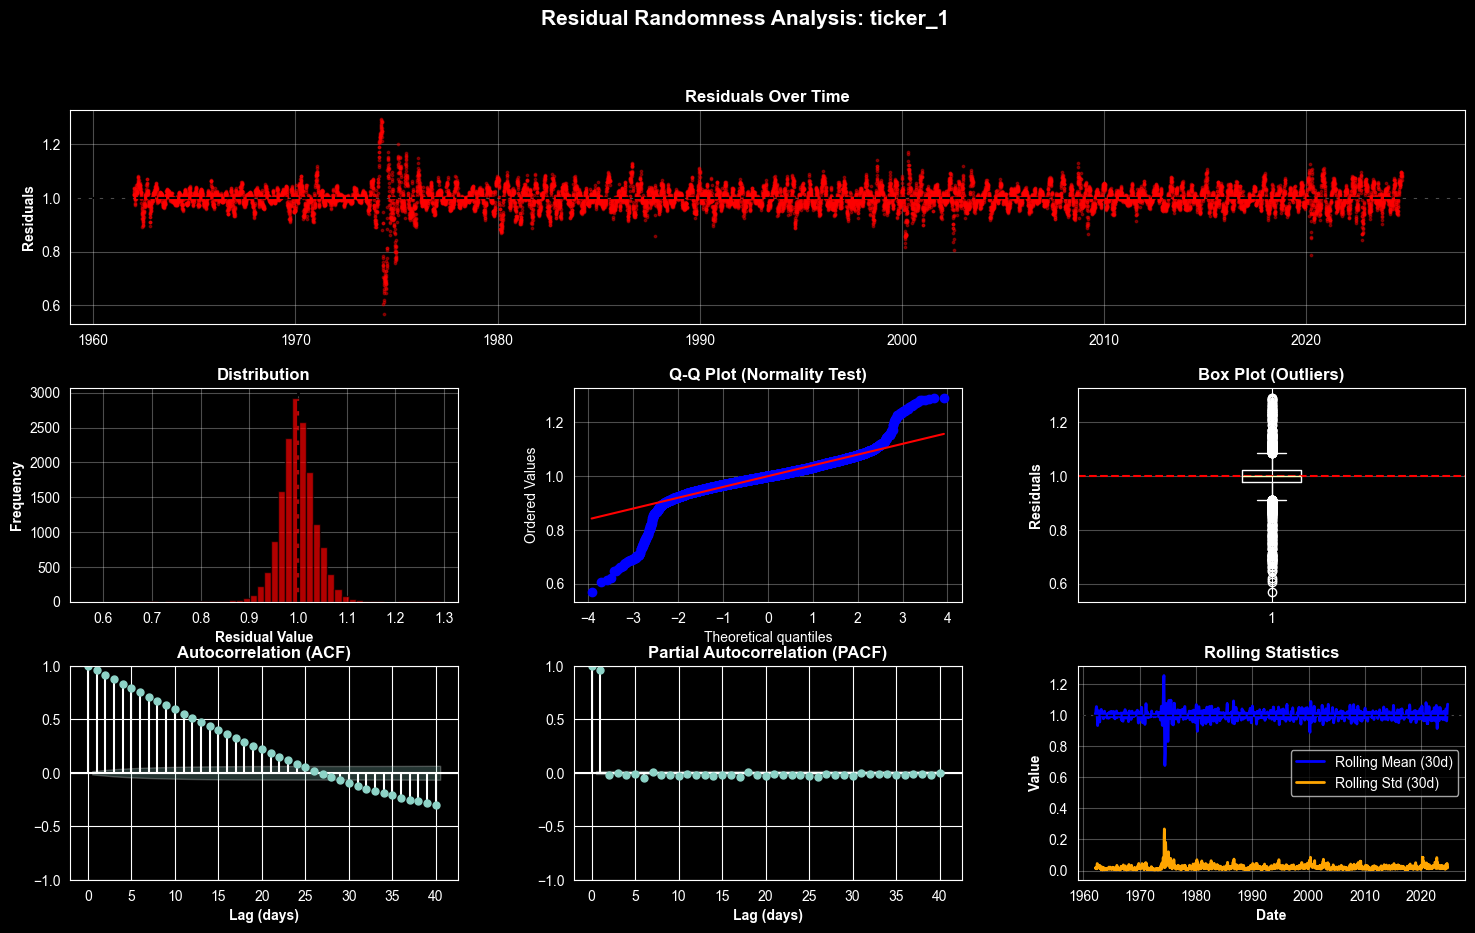


Randomness Tests:

Ljung-Box Test (H0: No autocorrelation):
          lb_stat  lb_pvalue
10   96683.874927        0.0
20  121700.308427        0.0
30  123226.901360        0.0
  ⚠️ WARNING: Significant autocorrelation detected at 3 lag(s)
  → Residuals contain patterns (NOT random)

Residual Analysis: ticker_4938

Descriptive Statistics:
  Mean: 0.388614 (should be ≈ 1.0 for multiplicative)
  Std Dev: 1.519769
  Skewness: -1.0993 (0 = symmetric)
  Kurtosis: 30.2432 (0 = normal)
  Min: -12.863552
  Max: 11.057553


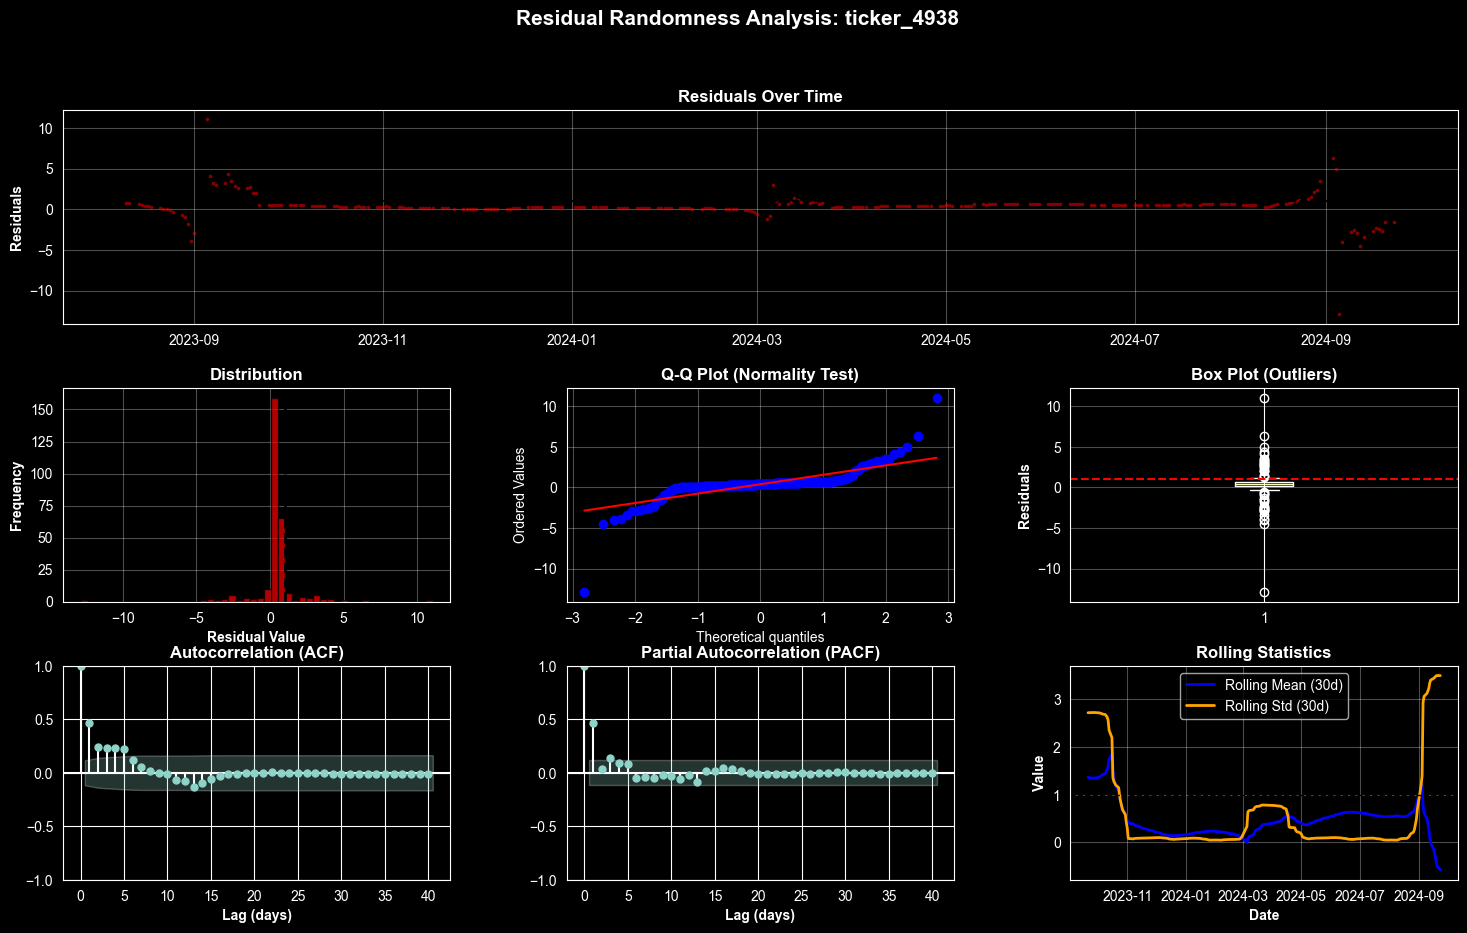


Randomness Tests:

Ljung-Box Test (H0: No autocorrelation):
       lb_stat     lb_pvalue
10  127.914851  1.243303e-22
20  140.572411  3.941497e-20
30  140.633034  2.984742e-16
  ⚠️ WARNING: Significant autocorrelation detected at 3 lag(s)
  → Residuals contain patterns (NOT random)

Residual Analysis: ticker_4917

Descriptive Statistics:
  Mean: 0.986653 (should be ≈ 1.0 for multiplicative)
  Std Dev: 0.066639
  Skewness: -0.2055 (0 = symmetric)
  Kurtosis: -1.0064 (0 = normal)
  Min: 0.841576
  Max: 1.119721


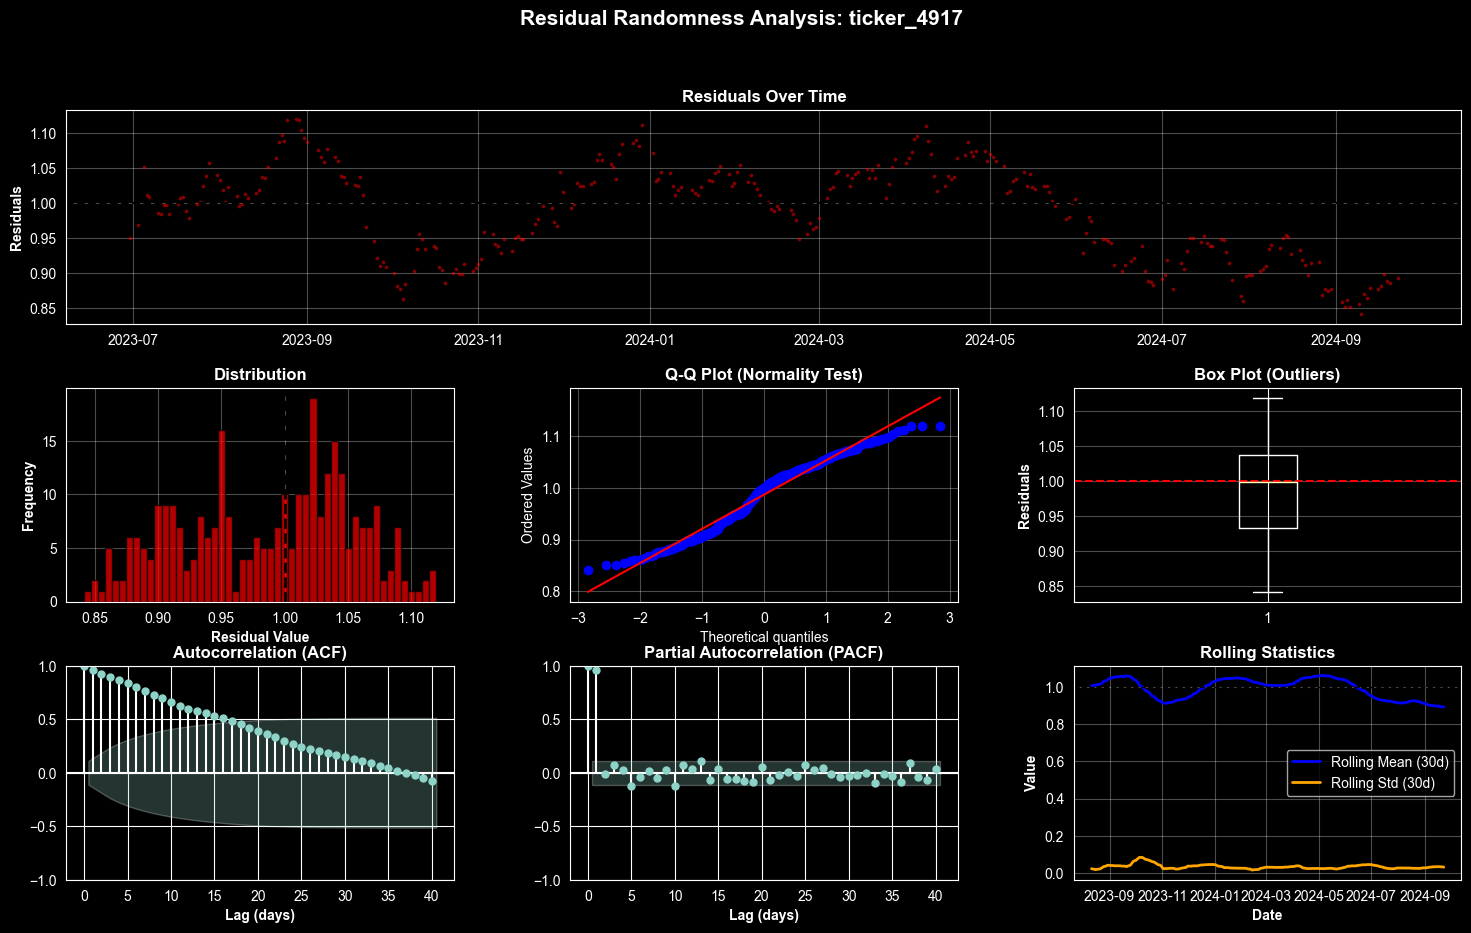


Randomness Tests:

Ljung-Box Test (H0: No autocorrelation):
        lb_stat  lb_pvalue
10  2132.733270        0.0
20  3021.242077        0.0
30  3235.151431        0.0
  ⚠️ WARNING: Significant autocorrelation detected at 3 lag(s)
  → Residuals contain patterns (NOT random)

Residual Analysis: ticker_2617

Descriptive Statistics:
  Mean: 0.999493 (should be ≈ 1.0 for multiplicative)
  Std Dev: 0.072441
  Skewness: -1.6251 (0 = symmetric)
  Kurtosis: 16.6037 (0 = normal)
  Min: 0.299306
  Max: 1.387119


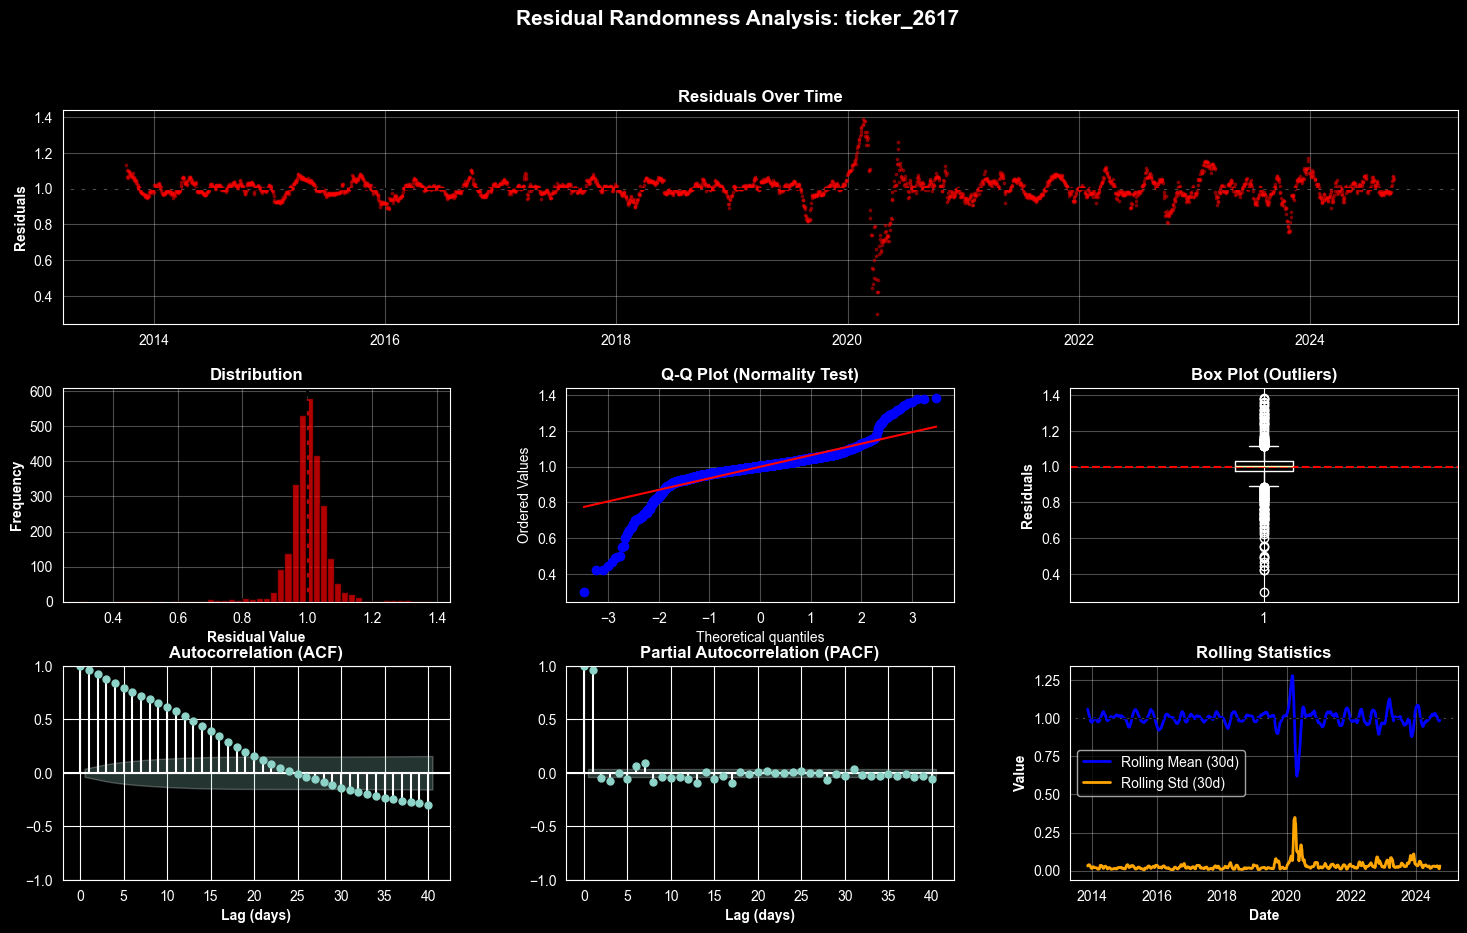


Randomness Tests:

Ljung-Box Test (H0: No autocorrelation):
         lb_stat  lb_pvalue
10  17258.274820        0.0
20  21425.135877        0.0
30  21619.708433        0.0
  ⚠️ WARNING: Significant autocorrelation detected at 3 lag(s)
  → Residuals contain patterns (NOT random)


In [25]:
# Detailed residual analysis for each stock
for ticker in selected_tickers:
    decomp = decompositions[ticker]['decomposition']
    residuals = decomp.resid.dropna()

    print(f"\n{'='*80}")
    print(f"Residual Analysis: {ticker}")
    print('='*80)

    # Statistics
    print(f"\nDescriptive Statistics:")
    print(f"  Mean: {residuals.mean():.6f} (should be ≈ 1.0 for multiplicative)")
    print(f"  Std Dev: {residuals.std():.6f}")
    print(f"  Skewness: {residuals.skew():.4f} (0 = symmetric)")
    print(f"  Kurtosis: {residuals.kurtosis():.4f} (0 = normal)")
    print(f"  Min: {residuals.min():.6f}")
    print(f"  Max: {residuals.max():.6f}")

    # Visualization
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    fig.suptitle(f'Residual Randomness Analysis: {ticker}',
                 fontsize=15, fontweight='bold')

    # 1. Time series plot
    ax1 = fig.add_subplot(gs[0, :])
    ax1.scatter(residuals.index, residuals.values, alpha=0.4, s=3, color='red')
    ax1.axhline(y=1, color='black', linestyle='--', linewidth=1.5)
    ax1.set_ylabel('Residuals', fontweight='bold')
    ax1.set_title('Residuals Over Time', fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # 2. Histogram
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.hist(residuals, bins=50, color='red', alpha=0.7, edgecolor='black')
    ax2.axvline(x=1, color='black', linestyle='--', linewidth=2)
    ax2.set_xlabel('Residual Value', fontweight='bold')
    ax2.set_ylabel('Frequency', fontweight='bold')
    ax2.set_title('Distribution', fontweight='bold')
    ax2.grid(True, alpha=0.3)

    # 3. Q-Q Plot
    ax3 = fig.add_subplot(gs[1, 1])
    scipy_stats.probplot(residuals, dist="norm", plot=ax3)
    ax3.set_title('Q-Q Plot (Normality Test)', fontweight='bold')
    ax3.grid(True, alpha=0.3)

    # 4. Box plot
    ax4 = fig.add_subplot(gs[1, 2])
    ax4.boxplot(residuals, vert=True)
    ax4.axhline(y=1, color='red', linestyle='--', linewidth=1.5)
    ax4.set_ylabel('Residuals', fontweight='bold')
    ax4.set_title('Box Plot (Outliers)', fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')

    # 5. ACF
    ax5 = fig.add_subplot(gs[2, 0])
    plot_acf(residuals, lags=40, ax=ax5, alpha=0.05)
    ax5.set_title('Autocorrelation (ACF)', fontweight='bold')
    ax5.set_xlabel('Lag (days)', fontweight='bold')

    # 6. PACF
    ax6 = fig.add_subplot(gs[2, 1])
    plot_pacf(residuals, lags=40, ax=ax6, alpha=0.05, method='ywm')
    ax6.set_title('Partial Autocorrelation (PACF)', fontweight='bold')
    ax6.set_xlabel('Lag (days)', fontweight='bold')

    # 7. Rolling statistics
    ax7 = fig.add_subplot(gs[2, 2])
    rolling_mean = residuals.rolling(window=30).mean()
    rolling_std = residuals.rolling(window=30).std()
    ax7.plot(residuals.index, rolling_mean, label='Rolling Mean (30d)',
            color='blue', linewidth=2)
    ax7.plot(residuals.index, rolling_std, label='Rolling Std (30d)',
            color='orange', linewidth=2)
    ax7.axhline(y=1, color='black', linestyle='--', linewidth=1)
    ax7.set_xlabel('Date', fontweight='bold')
    ax7.set_ylabel('Value', fontweight='bold')
    ax7.set_title('Rolling Statistics', fontweight='bold')
    ax7.legend()
    ax7.grid(True, alpha=0.3)

    plt.show()

    # Statistical tests
    print(f"\nRandomness Tests:")

    # Ljung-Box test for autocorrelation
    from statsmodels.stats.diagnostic import acorr_ljungbox
    lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
    print(f"\nLjung-Box Test (H0: No autocorrelation):")
    print(lb_test)

    # Interpretation
    significant_lags = lb_test[lb_test['lb_pvalue'] < 0.05]
    if len(significant_lags) > 0:
        print(f"  ⚠️ WARNING: Significant autocorrelation detected at {len(significant_lags)} lag(s)")
        print(f"  → Residuals contain patterns (NOT random)")
    else:
        print(f"  ✅ No significant autocorrelation detected")
        print(f"  → Residuals appear random")

# تحليل نتائج الضجيج وتطبيقاتها العملية

## أولاً: ما معنى النتائج السابقة؟ (فهم الضجيج)

### 1. قيمة المتوسط (Mean ≈ 1.0)
بما أنك تستخدم النموذج الضربي (Multiplicative Model)، فإن اقتراب المتوسط من `1.0` يعني أن عملية التفكيك تمت بشكل صحيح رياضياً.

### 2. الانحراف المعياري (Std Dev)
يقيس حجم المخاطرة أو **"الضجيج العشوائي"**. نلاحظ أن `ticker_1` هو الأكثر استقراراً (`0.04`)، بينما البقية لديهم ضجيج أعلى، مما يصعب مهمة التنبؤ قليلاً.

### 3. التفرطح (Kurtosis)
القيم العالية جداً (مثل `16.6` لسهم `ticker_2617`) تعني وجود **"ذيول سميكة"**، أي حدوث قفزات أو انهيارات مفاجئة (Outliers) أكثر مما يتوقعه التوزيع الطبيعي.

### 4. اختبار Ljung-Box (التحذير الأهم)
ظهور رسالة **"Significant autocorrelation detected"** يعني أن البقايا ليست عشوائية تماماً بل تحتوي على **"أنماط خفية"** لم يستطع التحليل التقليدي استخراجها.

---

## ثانياً: المستفاد من هذه النتائج لمشروعك (برمجياً)

### 1. اكتشاف الأنماط قصيرة المدى (Local Patterns)
بما أن الاختبار أثبت وجود علاقة (Autocorrelation) في البقايا، فهذا يعني وجود تغيرات سريعة في السعر أو ارتفاعات وانخفاضات مفاجئة يمكن للشبكة العصبونية (خاصة نوع **LSTM** أو **RNN**) أن تتعلمها وتستفيد منها في التنبؤ.

### 2. الحاجة لتقنيات التدريب (Training Techniques)
القيم العالية للتفرطح (Kurtosis) والالتواء (Skewness) تدل على وجود بيانات متطرفة. لضمان قدرة النموذج على **"التعميم" (Generalization)** وعدم حفظ الضجيج (Overfitting)، يجب عليك استخدام تقنيات مثل **Batch Normalization** أو **Dropout**.

### 3. تحسين الـ Score
وجود أنماط في البقايا هو **"كنز"** لنموذج الذكاء الصنعي؛ فبينما تفشل النماذج الإحصائية التقليدية في توقعها، تستطيع الشبكات العصبونية رصد هذه التداخلات المعقدة لتحقيق دقة أعلى في التنبؤ باتجاه الحركة (صعود أم هبوط).